In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

In [2]:
#Grab Data
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

In [3]:
#Split into X and Y (data and labels)
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

In [4]:
#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
                                    dataX, dataY, test_size=0.33, 
                                    random_state=2018, stratify=dataY)

In [6]:
#Scale the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

C:\Users\JMcKay\AppData\Local\Temp\ipykernel_14200\2030725818.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
C:\Users\JMcKay\AppData\Local\Temp\ipykernel_14200\2030725818.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])


In [5]:
#Create dF for the Autoencoder
X_train_AE, X_test_AE = X_train.copy(), X_test.copy()

In [6]:
#Define loss function - Squared difference normalized between 1 and 0, the closer to 0 the more valid an answer
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - 
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss
    

In [7]:
#Precision recall curve
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], 
                               preds['anomalyScore'])
    average_precision = average_precision_score( 
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], 
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [10]:
# Model One
# Two Layer Complete Autoencoder with linear activation

tf.random.set_seed(42)
np.random.seed(42)

# Call neural network API
model = Sequential()

# Apply linear activation function to input layer
# Generate hidden layer with 29 nodes, the same as the input layer as Units, input_dim is the number of nodes 
model.add(Dense(units=29, activation='linear',input_dim=29))

# Apply linear activation function to hidden layer
# Generate output layer with 29 nodes
model.add(Dense(units=29, activation='linear'))

In [11]:
# Compile the model
# Metrics is the evaluation metric to determine success 
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [12]:
# Train the model
num_epochs = 10 # determines number of times the training occurs over the entire dataset we pass into the network.
batch_size = 32 # Sets the number of samples the network trains on before making the next gradient update. If the batch is equal to the total number of observations, the network will make a gradient update once every epoch, otherwise it will make multiple updates per epoch.

# In the fit model X is the original matrix and Y is the target matrix we want to compare against. In this instance we want to compare the output to the original features.

history = model.fit(x=X_train_AE, y=X_train_AE,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_AE, X_train_AE),
                    verbose=1)

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0823 - accuracy: 0.8946 - val_loss: 0.0011 - val_accuracy: 0.9836
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 9.9651e-04 - accuracy: 0.9921 - val_loss: 1.4006e-05 - val_accuracy: 0.9983
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 7.5384e-04 - accuracy: 0.9929 - val_loss: 4.0721e-04 - val_accuracy: 0.9934
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 4.9105e-04 - accuracy: 0.9946 - val_loss: 1.7380e-06 - val_accuracy: 0.9994
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 6.9021e-04 - accuracy: 0.9938 - val_loss: 6.6438e-05 - val_accuracy: 0.9973
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 4.5186e-04 - accuracy: 0.9949 - val_loss: 0.0013 - val_accuracy: 0.9846
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 5.5186e-04 - accu

2938/2938 [==============================] - 6s 884us/step


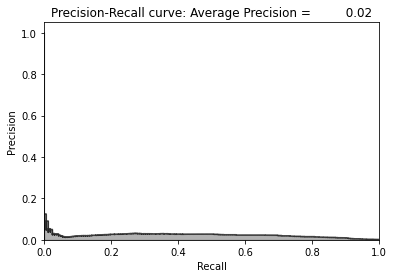

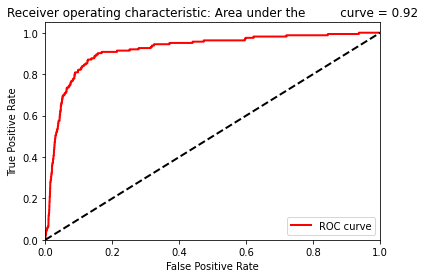

In [13]:
# The low loss of the test set indicates the Autoencoder is overfit to the dataset.
# Evaluation of the original test set (overfit)
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)
model.reset_states()

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.1018 - accuracy: 0.8694 - val_loss: 0.0019 - val_accuracy: 0.9778
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0010 - accuracy: 0.9920 - val_loss: 1.5867e-06 - val_accuracy: 0.9993
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.2532e-04 - accuracy: 0.9926 - val_loss: 3.3313e-04 - val_accuracy: 0.9937
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.0867e-04 - accuracy: 0.9944 - val_loss: 1.4990e-05 - val_accuracy: 0.9980
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 7.5393e-04 - accuracy: 0.9938 - val_loss: 3.2852e-05 - val_accuracy: 0.9973
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.0999e-04 - accuracy: 0.9945 - val_loss: 0.0016 - val_accuracy: 0.9788
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.0661e-04 - accuracy

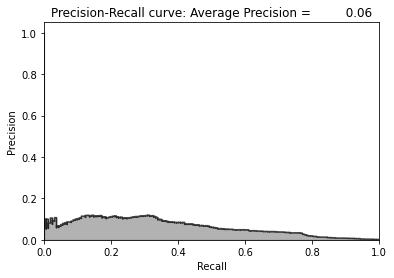

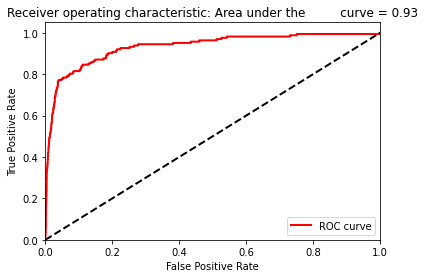

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0820 - accuracy: 0.8918 - val_loss: 0.0017 - val_accuracy: 0.9748
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.2770e-04 - accuracy: 0.9921 - val_loss: 2.4651e-04 - val_accuracy: 0.9952
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.0015e-04 - accuracy: 0.9944 - val_loss: 2.4749e-04 - val_accuracy: 0.9913
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.3785e-04 - accuracy: 0.9940 - val_loss: 1.2735e-06 - val_accuracy: 0.9996
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.3468e-04 - accuracy: 0.9937 - val_loss: 9.2301e-05 - val_accuracy: 0.9967
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.5063e-04 - accuracy: 0.9944 - val_loss: 7.9629e-04 - val_accuracy: 0.9881
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 4.7870e-04 - 

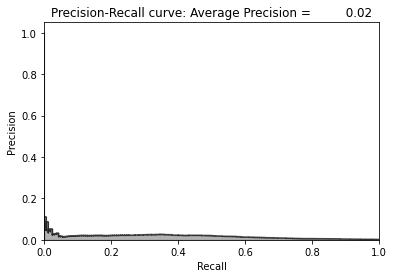

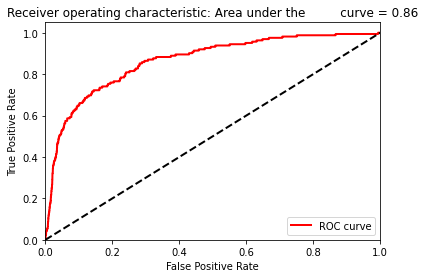

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0821 - accuracy: 0.9004 - val_loss: 0.0022 - val_accuracy: 0.9832
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0024 - accuracy: 0.9854 - val_loss: 4.5054e-04 - val_accuracy: 0.9929
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 6.9861e-04 - accuracy: 0.9923 - val_loss: 9.7413e-04 - val_accuracy: 0.9929
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.4169e-04 - accuracy: 0.9938 - val_loss: 4.8868e-06 - val_accuracy: 0.9992
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.2386e-04 - accuracy: 0.9928 - val_loss: 7.1704e-05 - val_accuracy: 0.9962
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 4.5417e-04 - accuracy: 0.9948 - val_loss: 0.0013 - val_accuracy: 0.9835
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.3743e-04 - accuracy

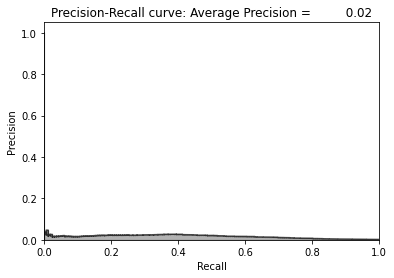

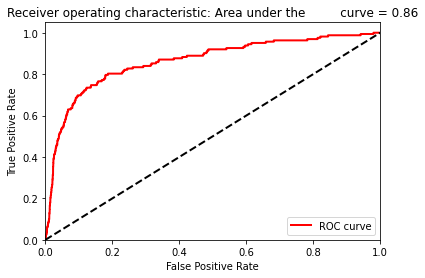

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0894 - accuracy: 0.8923 - val_loss: 0.0011 - val_accuracy: 0.9803
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.2285e-04 - accuracy: 0.9936 - val_loss: 6.6625e-05 - val_accuracy: 0.9963
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 7.6061e-04 - accuracy: 0.9932 - val_loss: 1.9886e-04 - val_accuracy: 0.9948
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.1754e-04 - accuracy: 0.9946 - val_loss: 1.6422e-06 - val_accuracy: 0.9994
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.7548e-04 - accuracy: 0.9936 - val_loss: 3.3497e-05 - val_accuracy: 0.9971
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.1662e-04 - accuracy: 0.9949 - val_loss: 8.4844e-04 - val_accuracy: 0.9896
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 4.3915e-04 - 

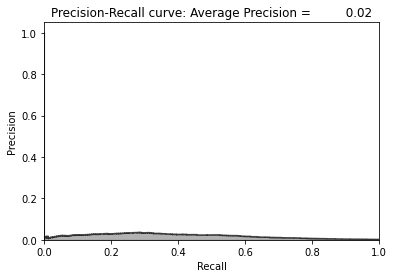

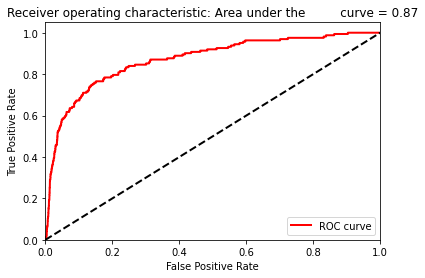

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0919 - accuracy: 0.8819 - val_loss: 0.0017 - val_accuracy: 0.9824
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0013 - accuracy: 0.9905 - val_loss: 4.5465e-06 - val_accuracy: 0.9989
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 7.7238e-04 - accuracy: 0.9933 - val_loss: 2.2528e-04 - val_accuracy: 0.9949
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 4.3322e-04 - accuracy: 0.9949 - val_loss: 4.2474e-04 - val_accuracy: 0.9969
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.2325e-04 - accuracy: 0.9929 - val_loss: 2.7717e-05 - val_accuracy: 0.9971
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 4.7950e-04 - accuracy: 0.9957 - val_loss: 0.0017 - val_accuracy: 0.9804
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 4.7464e-04 - accuracy

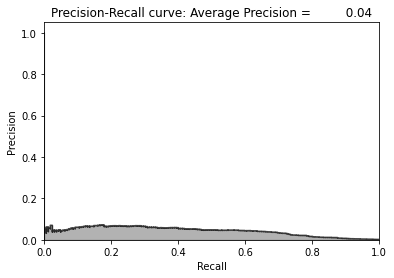

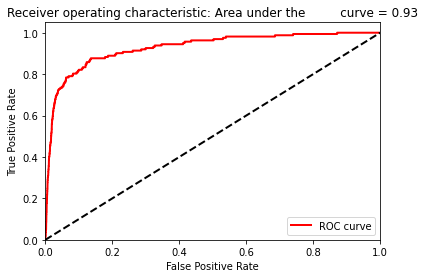

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0861 - accuracy: 0.8942 - val_loss: 0.0023 - val_accuracy: 0.9791
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0022 - accuracy: 0.9851 - val_loss: 5.3453e-04 - val_accuracy: 0.9903
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.1683e-04 - accuracy: 0.9925 - val_loss: 6.1950e-04 - val_accuracy: 0.9904
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.8362e-04 - accuracy: 0.9951 - val_loss: 7.0539e-07 - val_accuracy: 0.9997
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.7193e-04 - accuracy: 0.9942 - val_loss: 6.8739e-05 - val_accuracy: 0.9967
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.0043e-04 - accuracy: 0.9944 - val_loss: 0.0010 - val_accuracy: 0.9840
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.3639e-04 - accuracy

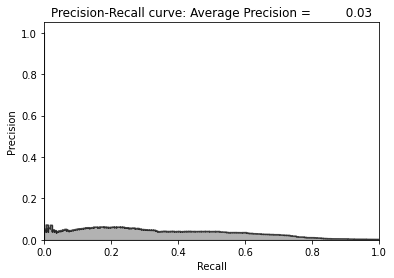

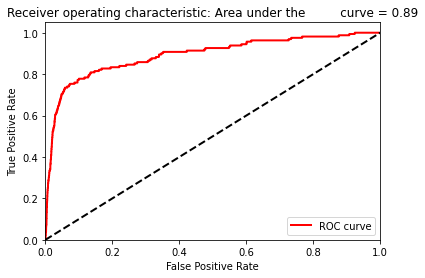

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0825 - accuracy: 0.8948 - val_loss: 0.0016 - val_accuracy: 0.9818
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.7563e-04 - accuracy: 0.9919 - val_loss: 6.7404e-04 - val_accuracy: 0.9895
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.5479e-04 - accuracy: 0.9935 - val_loss: 3.4722e-04 - val_accuracy: 0.9922
Epoch 4/10
5964/5964 [==============================] - 15s 3ms/step - loss: 4.8367e-04 - accuracy: 0.9943 - val_loss: 1.0107e-06 - val_accuracy: 0.9997
Epoch 5/10
5964/5964 [==============================] - 18s 3ms/step - loss: 7.2965e-04 - accuracy: 0.9930 - val_loss: 1.7898e-04 - val_accuracy: 0.9948
Epoch 6/10
5964/5964 [==============================] - 14s 2ms/step - loss: 5.4737e-04 - accuracy: 0.9946 - val_loss: 6.6805e-04 - val_accuracy: 0.9886
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 4.0484e-04 - 

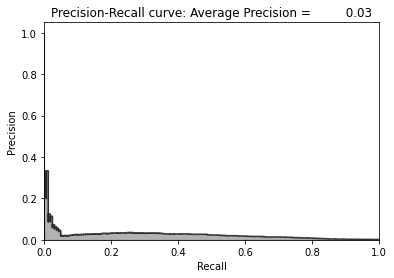

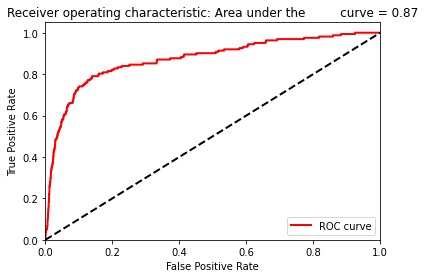

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0794 - accuracy: 0.8964 - val_loss: 0.0021 - val_accuracy: 0.9776
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0013 - accuracy: 0.9898 - val_loss: 6.1333e-04 - val_accuracy: 0.9896
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 9.3012e-04 - accuracy: 0.9932 - val_loss: 4.2433e-04 - val_accuracy: 0.9926
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 4.7673e-04 - accuracy: 0.9944 - val_loss: 7.8180e-04 - val_accuracy: 0.9935
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 7.1355e-04 - accuracy: 0.9928 - val_loss: 8.6368e-05 - val_accuracy: 0.9960
Epoch 6/10
5964/5964 [==============================] - 15s 2ms/step - loss: 4.3733e-04 - accuracy: 0.9949 - val_loss: 0.0019 - val_accuracy: 0.9764
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.8201e-04 - accuracy

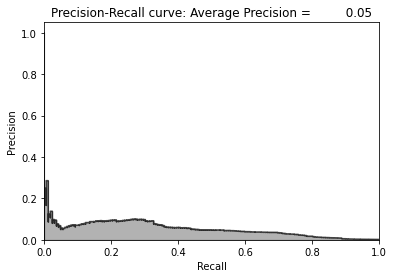

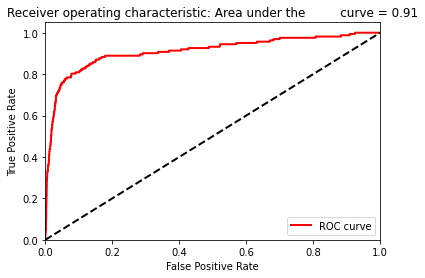

Epoch 1/10
5964/5964 [==============================] - 18s 3ms/step - loss: 0.0811 - accuracy: 0.8955 - val_loss: 0.0015 - val_accuracy: 0.9746
Epoch 2/10
5964/5964 [==============================] - 15s 2ms/step - loss: 8.8306e-04 - accuracy: 0.9917 - val_loss: 2.0596e-04 - val_accuracy: 0.9936
Epoch 3/10
5964/5964 [==============================] - 15s 2ms/step - loss: 8.8676e-04 - accuracy: 0.9930 - val_loss: 0.0011 - val_accuracy: 0.9869
Epoch 4/10
5964/5964 [==============================] - 14s 2ms/step - loss: 4.8436e-04 - accuracy: 0.9950 - val_loss: 8.4465e-07 - val_accuracy: 0.9997
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.9153e-04 - accuracy: 0.9935 - val_loss: 2.0931e-05 - val_accuracy: 0.9979
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 4.8007e-04 - accuracy: 0.9948 - val_loss: 0.0011 - val_accuracy: 0.9850
Epoch 7/10
5964/5964 [==============================] - 14s 2ms/step - loss: 6.5276e-04 - accuracy

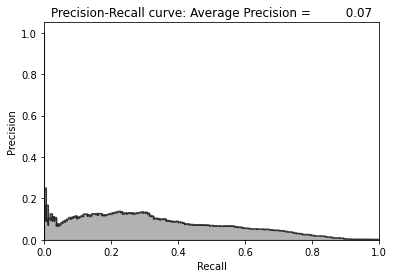

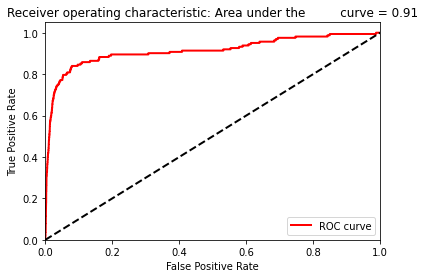

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0832 - accuracy: 0.8957 - val_loss: 0.0020 - val_accuracy: 0.9784
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0011 - accuracy: 0.9914 - val_loss: 4.2364e-05 - val_accuracy: 0.9974
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 6.5790e-04 - accuracy: 0.9934 - val_loss: 2.8920e-04 - val_accuracy: 0.9942
Epoch 4/10
5964/5964 [==============================] - 15s 3ms/step - loss: 4.8888e-04 - accuracy: 0.9944 - val_loss: 3.3735e-06 - val_accuracy: 0.9992
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 7.1328e-04 - accuracy: 0.9931 - val_loss: 3.4278e-04 - val_accuracy: 0.9932
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 5.4909e-04 - accuracy: 0.9947 - val_loss: 7.2094e-04 - val_accuracy: 0.9886
Epoch 7/10
5964/5964 [==============================] - 14s 2ms/step - loss: 5.3038e-04 - accu

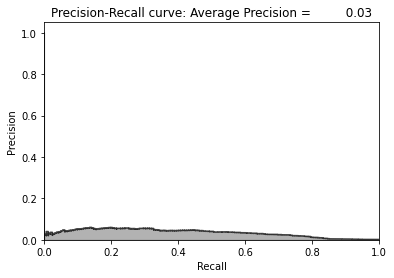

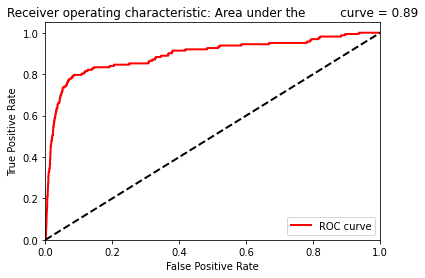

Mean average precision over 10 runs: 0.037487511752106586


[0.0628,
 0.0167,
 0.0162,
 0.0184,
 0.0426,
 0.0338,
 0.0258,
 0.0532,
 0.0711,
 0.0342]

In [14]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 29 nodes, the same as the input layer
    model.add(Dense(units=29, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f'Mean average precision over 10 runs: {np.mean(test_scores)}')
[round(x,4) for x in test_scores]

In [15]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0375
Coefficient of variation over 10 runs: 0.4959


[0.0628,
 0.0167,
 0.0162,
 0.0184,
 0.0426,
 0.0338,
 0.0258,
 0.0532,
 0.0711,
 0.0342]

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.3463 - accuracy: 0.5856 - val_loss: 0.2780 - val_accuracy: 0.6435
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2810 - accuracy: 0.6406 - val_loss: 0.2753 - val_accuracy: 0.6338
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2789 - accuracy: 0.6467 - val_loss: 0.2740 - val_accuracy: 0.6413
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2773 - accuracy: 0.6484 - val_loss: 0.2744 - val_accuracy: 0.6533
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2767 - accuracy: 0.6512 - val_loss: 0.2732 - val_accuracy: 0.6609
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2767 - accuracy: 0.6627 - val_loss: 0.2735 - val_accuracy: 0.6584
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2765 - accuracy: 0.6645 - val_loss: 0.2736 - val_ac

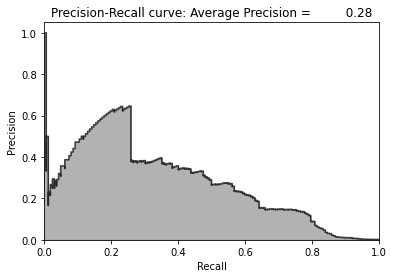

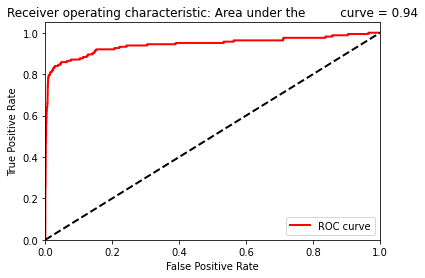

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.3446 - accuracy: 0.5553 - val_loss: 0.2778 - val_accuracy: 0.6169
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2805 - accuracy: 0.6240 - val_loss: 0.2752 - val_accuracy: 0.6392
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2784 - accuracy: 0.6416 - val_loss: 0.2740 - val_accuracy: 0.6431
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2775 - accuracy: 0.6455 - val_loss: 0.2746 - val_accuracy: 0.6387
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2769 - accuracy: 0.6510 - val_loss: 0.2733 - val_accuracy: 0.6491
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2767 - accuracy: 0.6473 - val_loss: 0.2738 - val_accuracy: 0.6531
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2766 - accuracy: 0.6542 - val_loss: 0.2741 - val_ac

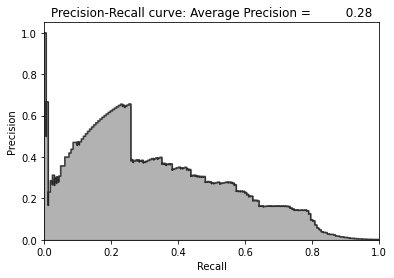

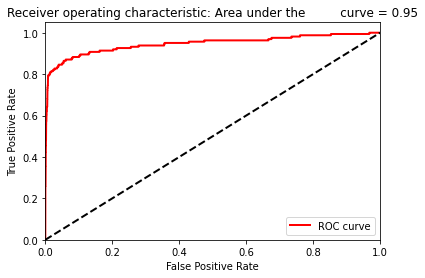

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.3459 - accuracy: 0.5622 - val_loss: 0.2791 - val_accuracy: 0.6320
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2820 - accuracy: 0.6455 - val_loss: 0.2757 - val_accuracy: 0.6553
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2793 - accuracy: 0.6699 - val_loss: 0.2743 - val_accuracy: 0.6696
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2778 - accuracy: 0.6634 - val_loss: 0.2745 - val_accuracy: 0.6668
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2772 - accuracy: 0.6645 - val_loss: 0.2736 - val_accuracy: 0.6672
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2769 - accuracy: 0.6584 - val_loss: 0.2739 - val_accuracy: 0.6647
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2767 - accuracy: 0.6632 - val_loss: 0.2742 - val_ac

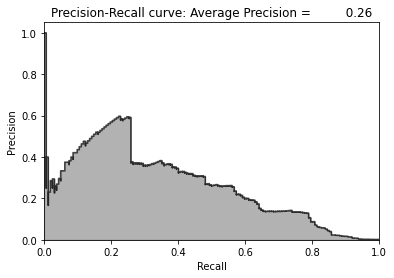

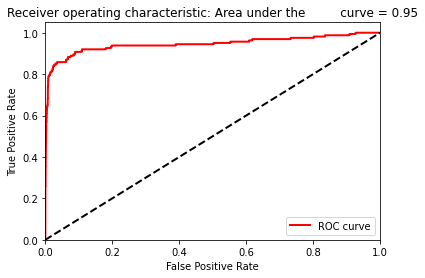

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.3435 - accuracy: 0.5435 - val_loss: 0.2784 - val_accuracy: 0.6037
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2812 - accuracy: 0.6119 - val_loss: 0.2756 - val_accuracy: 0.6261
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2790 - accuracy: 0.6360 - val_loss: 0.2741 - val_accuracy: 0.6378
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2775 - accuracy: 0.6483 - val_loss: 0.2744 - val_accuracy: 0.6394
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2769 - accuracy: 0.6373 - val_loss: 0.2733 - val_accuracy: 0.6414
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2768 - accuracy: 0.6374 - val_loss: 0.2740 - val_accuracy: 0.6414
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2767 - accuracy: 0.6357 - val_loss: 0.2743 - val_ac

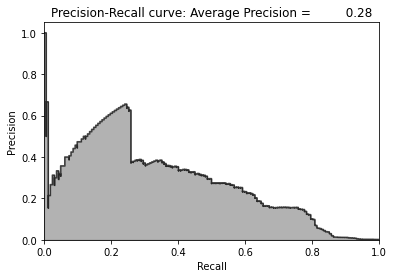

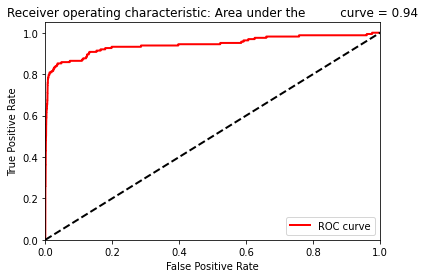

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.3503 - accuracy: 0.5366 - val_loss: 0.2780 - val_accuracy: 0.5982
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2809 - accuracy: 0.6103 - val_loss: 0.2753 - val_accuracy: 0.6117
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2785 - accuracy: 0.6218 - val_loss: 0.2743 - val_accuracy: 0.6300
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2779 - accuracy: 0.6443 - val_loss: 0.2748 - val_accuracy: 0.6354
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2771 - accuracy: 0.6352 - val_loss: 0.2736 - val_accuracy: 0.6428
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2769 - accuracy: 0.6410 - val_loss: 0.2740 - val_accuracy: 0.6416
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2769 - accuracy: 0.6421 - val_loss: 0.2742 - val_ac

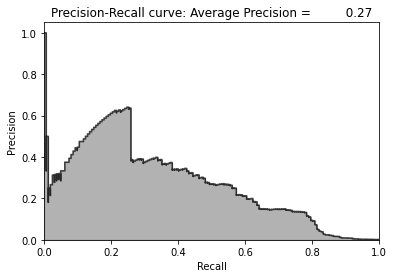

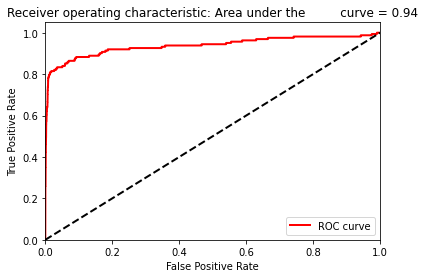

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.3502 - accuracy: 0.5810 - val_loss: 0.2791 - val_accuracy: 0.6367
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2810 - accuracy: 0.6382 - val_loss: 0.2761 - val_accuracy: 0.6496
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2791 - accuracy: 0.6630 - val_loss: 0.2749 - val_accuracy: 0.6517
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2780 - accuracy: 0.6599 - val_loss: 0.2748 - val_accuracy: 0.6539
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2770 - accuracy: 0.6634 - val_loss: 0.2735 - val_accuracy: 0.6597
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2768 - accuracy: 0.6595 - val_loss: 0.2741 - val_accuracy: 0.6692
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2767 - accuracy: 0.6734 - val_loss: 0.2742 - val_ac

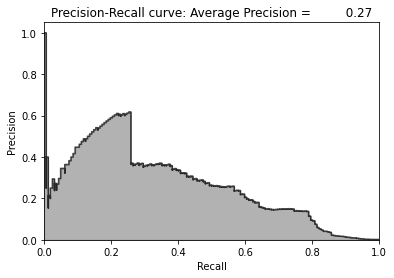

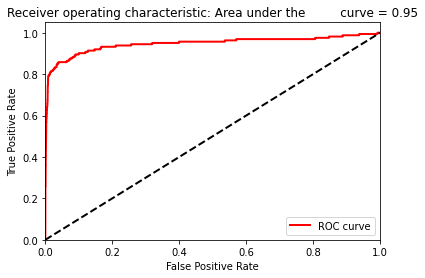

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.3451 - accuracy: 0.5345 - val_loss: 0.2788 - val_accuracy: 0.5749
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2812 - accuracy: 0.5758 - val_loss: 0.2759 - val_accuracy: 0.5731
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.2793 - accuracy: 0.5819 - val_loss: 0.2746 - val_accuracy: 0.5731
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2779 - accuracy: 0.5869 - val_loss: 0.2749 - val_accuracy: 0.5876
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.2774 - accuracy: 0.5973 - val_loss: 0.2738 - val_accuracy: 0.6063
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2773 - accuracy: 0.6055 - val_loss: 0.2744 - val_accuracy: 0.6095
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.2772 - accuracy: 0.6163 - val_loss: 0.2753 - val_ac

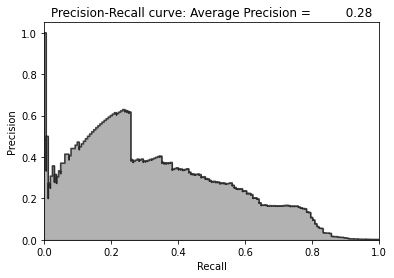

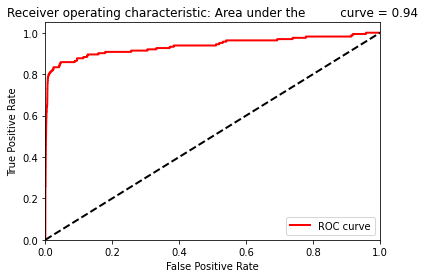

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.3611 - accuracy: 0.5434 - val_loss: 0.2783 - val_accuracy: 0.6143
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2810 - accuracy: 0.6061 - val_loss: 0.2753 - val_accuracy: 0.6202
Epoch 3/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.2787 - accuracy: 0.6240 - val_loss: 0.2740 - val_accuracy: 0.6374
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2775 - accuracy: 0.6589 - val_loss: 0.2743 - val_accuracy: 0.6483
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2767 - accuracy: 0.6513 - val_loss: 0.2730 - val_accuracy: 0.6524
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.2767 - accuracy: 0.6527 - val_loss: 0.2736 - val_accuracy: 0.6477
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2767 - accuracy: 0.6584 - val_loss: 0.2736 - val_ac

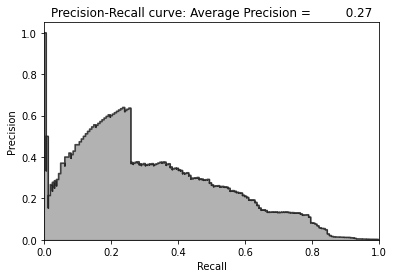

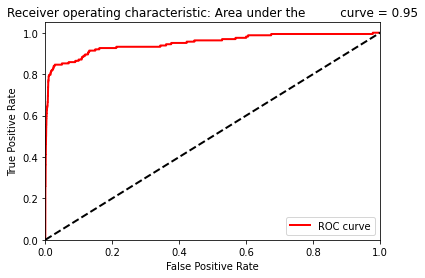

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.3389 - accuracy: 0.5604 - val_loss: 0.2786 - val_accuracy: 0.6051
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2814 - accuracy: 0.6186 - val_loss: 0.2761 - val_accuracy: 0.6221
Epoch 3/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.2794 - accuracy: 0.6453 - val_loss: 0.2745 - val_accuracy: 0.6381
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2779 - accuracy: 0.6427 - val_loss: 0.2746 - val_accuracy: 0.6432
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2769 - accuracy: 0.6479 - val_loss: 0.2734 - val_accuracy: 0.6472
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2766 - accuracy: 0.6466 - val_loss: 0.2739 - val_accuracy: 0.6498
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.2766 - accuracy: 0.6552 - val_loss: 0.2737 - val_ac

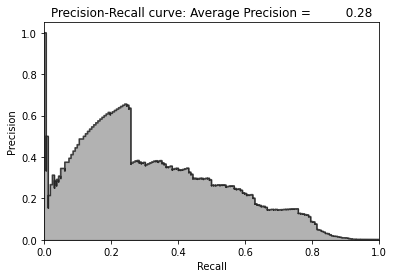

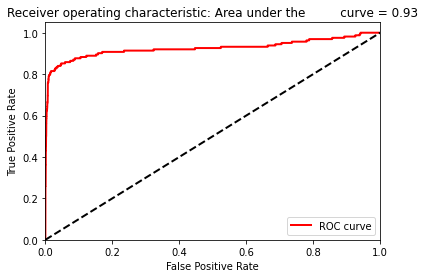

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.3493 - accuracy: 0.5359 - val_loss: 0.2801 - val_accuracy: 0.5858
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2823 - accuracy: 0.5968 - val_loss: 0.2768 - val_accuracy: 0.6055
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2801 - accuracy: 0.6209 - val_loss: 0.2752 - val_accuracy: 0.6374
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2782 - accuracy: 0.6527 - val_loss: 0.2750 - val_accuracy: 0.6591
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2774 - accuracy: 0.6662 - val_loss: 0.2737 - val_accuracy: 0.6645
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2772 - accuracy: 0.6587 - val_loss: 0.2743 - val_accuracy: 0.6672
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2770 - accuracy: 0.6638 - val_loss: 0.2742 - val_ac

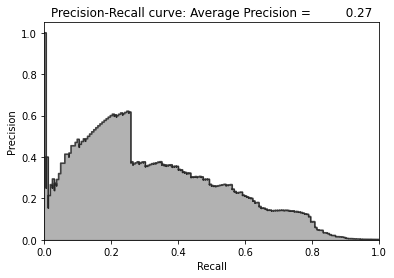

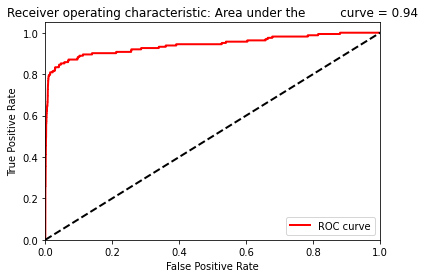

Mean average precision over 10 runs: 0.2752


[0.2799, 0.2837, 0.2649, 0.2822, 0.2744, 0.2674, 0.2816, 0.2711, 0.2755, 0.271]

In [16]:
#Model Two - Two layer undercomplete autoencoder with linear activation - Instead of setting the nodes in the hidden layer to the original dimension, we will set it to 20 (from 29). We should expect higher loss due to less nodes/dimensions

tf.random.set_seed(42)
np.random.seed(42)

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 20 nodes
    model.add(Dense(units=20, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [17]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.2752
Coefficient of variation over 10 runs: 0.0225


[0.2799, 0.2837, 0.2649, 0.2822, 0.2744, 0.2674, 0.2816, 0.2711, 0.2755, 0.271]

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.1202 - accuracy: 0.8331 - val_loss: 0.0378 - val_accuracy: 0.9187
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0382 - accuracy: 0.9116 - val_loss: 0.0356 - val_accuracy: 0.9076
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0374 - accuracy: 0.9187 - val_loss: 0.0347 - val_accuracy: 0.9100
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0359 - accuracy: 0.9418 - val_loss: 0.0362 - val_accuracy: 0.9285
Epoch 5/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0372 - accuracy: 0.9375 - val_loss: 0.0344 - val_accuracy: 0.9527
Epoch 6/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0355 - accuracy: 0.9532 - val_loss: 0.0351 - val_accuracy: 0.9252
Epoch 7/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0358 - accuracy: 0.9507 - val_loss: 0.0384 - val_ac

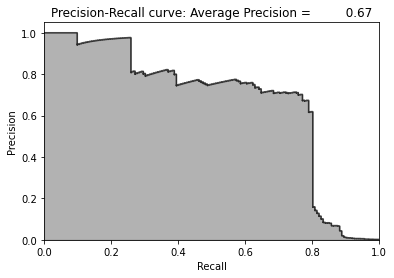

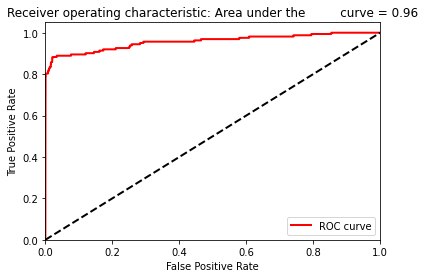

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.1140 - accuracy: 0.8131 - val_loss: 0.0374 - val_accuracy: 0.9038
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0399 - accuracy: 0.9157 - val_loss: 0.0361 - val_accuracy: 0.9305
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0387 - accuracy: 0.9347 - val_loss: 0.0368 - val_accuracy: 0.9523
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0382 - accuracy: 0.9575 - val_loss: 0.0377 - val_accuracy: 0.9560
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0381 - accuracy: 0.9607 - val_loss: 0.0360 - val_accuracy: 0.9668
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0387 - accuracy: 0.9616 - val_loss: 0.0365 - val_accuracy: 0.9581
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0391 - accuracy: 0.9616 - val_loss: 0.0373 - val_ac

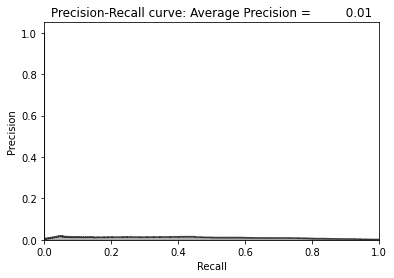

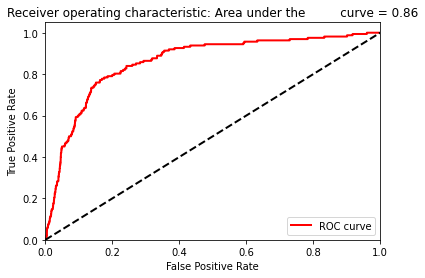

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.1255 - accuracy: 0.8170 - val_loss: 0.0365 - val_accuracy: 0.9057
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0399 - accuracy: 0.9199 - val_loss: 0.0361 - val_accuracy: 0.9249
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0385 - accuracy: 0.9255 - val_loss: 0.0357 - val_accuracy: 0.9258
Epoch 4/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0367 - accuracy: 0.9362 - val_loss: 0.0352 - val_accuracy: 0.9246
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0364 - accuracy: 0.9347 - val_loss: 0.0341 - val_accuracy: 0.9506
Epoch 6/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0354 - accuracy: 0.9501 - val_loss: 0.0355 - val_accuracy: 0.9259
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0370 - accuracy: 0.9480 - val_loss: 0.0355 - val_ac

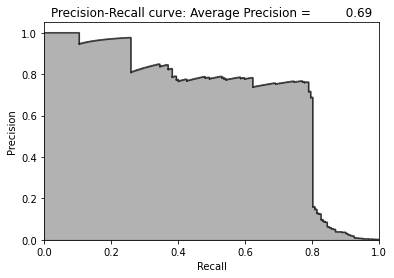

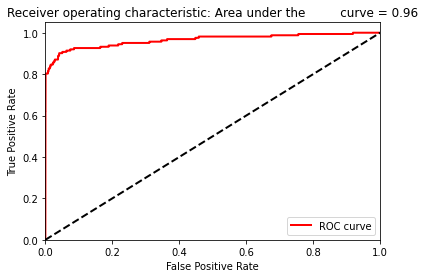

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.1237 - accuracy: 0.8175 - val_loss: 0.0378 - val_accuracy: 0.9333
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0399 - accuracy: 0.9461 - val_loss: 0.0369 - val_accuracy: 0.9508
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0394 - accuracy: 0.9512 - val_loss: 0.0383 - val_accuracy: 0.9594
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0383 - accuracy: 0.9603 - val_loss: 0.0378 - val_accuracy: 0.9602
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0388 - accuracy: 0.9604 - val_loss: 0.0365 - val_accuracy: 0.9668
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0391 - accuracy: 0.9561 - val_loss: 0.0376 - val_accuracy: 0.9520
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0391 - accuracy: 0.9596 - val_loss: 0.0367 - val_ac

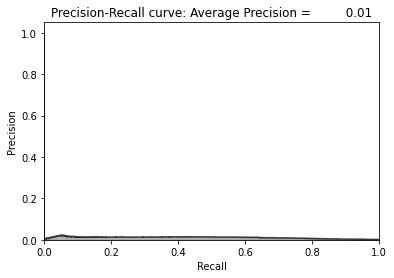

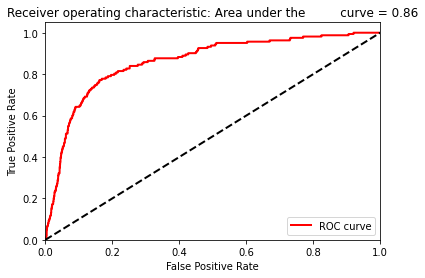

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.1398 - accuracy: 0.7997 - val_loss: 0.0379 - val_accuracy: 0.8800
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0390 - accuracy: 0.8823 - val_loss: 0.0363 - val_accuracy: 0.8808
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0387 - accuracy: 0.8877 - val_loss: 0.0363 - val_accuracy: 0.9172
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0388 - accuracy: 0.9274 - val_loss: 0.0369 - val_accuracy: 0.9384
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0384 - accuracy: 0.9427 - val_loss: 0.0360 - val_accuracy: 0.9533
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0391 - accuracy: 0.9483 - val_loss: 0.0373 - val_accuracy: 0.9432
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0390 - accuracy: 0.9542 - val_loss: 0.0373 - val_ac

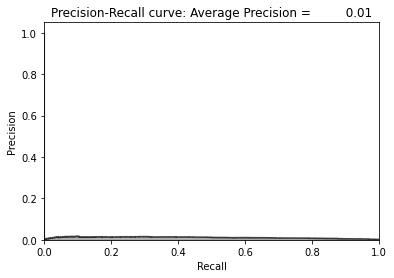

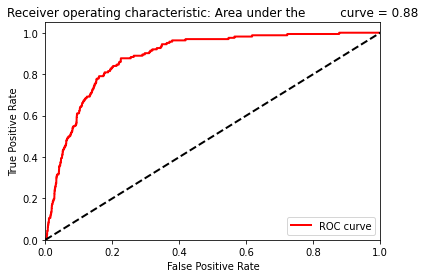

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.1221 - accuracy: 0.8247 - val_loss: 0.0367 - val_accuracy: 0.8913
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0381 - accuracy: 0.9027 - val_loss: 0.0350 - val_accuracy: 0.9041
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0367 - accuracy: 0.9315 - val_loss: 0.0352 - val_accuracy: 0.9316
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0361 - accuracy: 0.9425 - val_loss: 0.0354 - val_accuracy: 0.9322
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0360 - accuracy: 0.9349 - val_loss: 0.0344 - val_accuracy: 0.9509
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0367 - accuracy: 0.9474 - val_loss: 0.0349 - val_accuracy: 0.9278
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0357 - accuracy: 0.9503 - val_loss: 0.0377 - val_ac

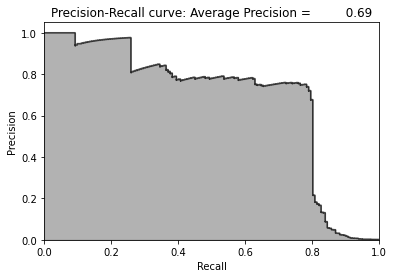

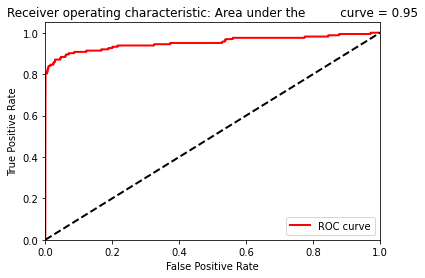

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.1211 - accuracy: 0.7950 - val_loss: 0.0377 - val_accuracy: 0.8883
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0399 - accuracy: 0.9110 - val_loss: 0.0371 - val_accuracy: 0.9263
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0393 - accuracy: 0.9314 - val_loss: 0.0375 - val_accuracy: 0.9477
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0386 - accuracy: 0.9528 - val_loss: 0.0377 - val_accuracy: 0.9523
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0388 - accuracy: 0.9557 - val_loss: 0.0365 - val_accuracy: 0.9618
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0392 - accuracy: 0.9564 - val_loss: 0.0370 - val_accuracy: 0.9580
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0390 - accuracy: 0.9596 - val_loss: 0.0371 - val_ac

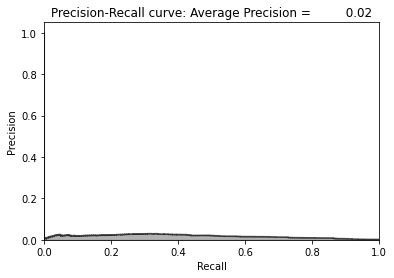

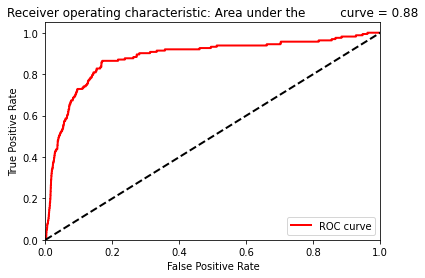

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.1179 - accuracy: 0.8003 - val_loss: 0.0376 - val_accuracy: 0.8855
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0387 - accuracy: 0.8575 - val_loss: 0.0360 - val_accuracy: 0.8465
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0384 - accuracy: 0.8711 - val_loss: 0.0370 - val_accuracy: 0.9049
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0391 - accuracy: 0.9204 - val_loss: 0.0369 - val_accuracy: 0.9294
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0393 - accuracy: 0.9349 - val_loss: 0.0361 - val_accuracy: 0.9475
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.0395 - accuracy: 0.9436 - val_loss: 0.0370 - val_accuracy: 0.9390
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0392 - accuracy: 0.9496 - val_loss: 0.0376 - val_ac

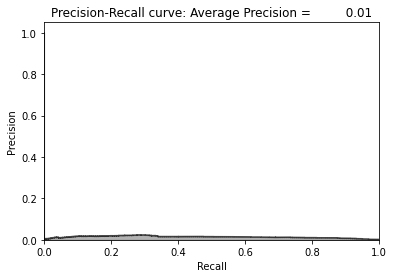

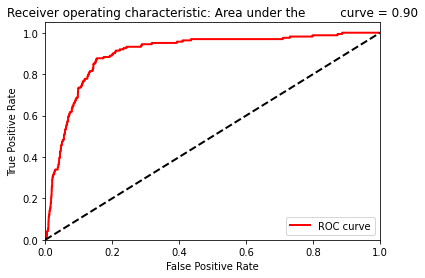

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.1174 - accuracy: 0.8165 - val_loss: 0.0367 - val_accuracy: 0.9227
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0404 - accuracy: 0.9356 - val_loss: 0.0366 - val_accuracy: 0.9534
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0393 - accuracy: 0.9532 - val_loss: 0.0370 - val_accuracy: 0.9600
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0384 - accuracy: 0.9620 - val_loss: 0.0381 - val_accuracy: 0.9528
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0386 - accuracy: 0.9563 - val_loss: 0.0363 - val_accuracy: 0.9643
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0390 - accuracy: 0.9575 - val_loss: 0.0369 - val_accuracy: 0.9588
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0391 - accuracy: 0.9606 - val_loss: 0.0374 - val_ac

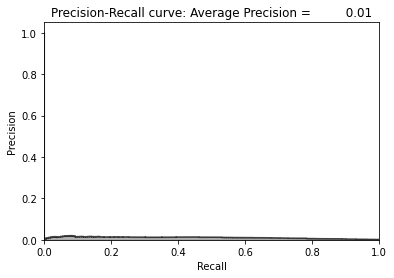

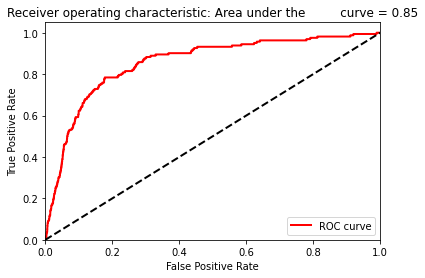

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.1198 - accuracy: 0.8358 - val_loss: 0.0378 - val_accuracy: 0.9242
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0391 - accuracy: 0.9182 - val_loss: 0.0358 - val_accuracy: 0.9161
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0379 - accuracy: 0.9249 - val_loss: 0.0363 - val_accuracy: 0.9328
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0380 - accuracy: 0.9374 - val_loss: 0.0363 - val_accuracy: 0.9491
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0382 - accuracy: 0.9513 - val_loss: 0.0360 - val_accuracy: 0.9601
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.0389 - accuracy: 0.9544 - val_loss: 0.0364 - val_accuracy: 0.9577
Epoch 7/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.0390 - accuracy: 0.9590 - val_loss: 0.0369 - val_ac

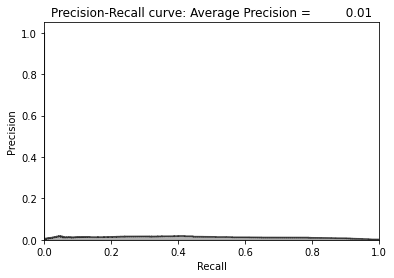

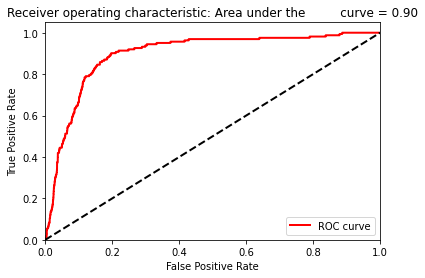

Mean average precision over 10 runs: 0.2135


[0.6722, 0.0105, 0.6879, 0.0113, 0.011, 0.6875, 0.0173, 0.014, 0.0108, 0.0126]

In [18]:
# 10 runs - We will capture mean of average precision - 27 Nodes vs. 29 or 20
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 27 nodes
    model.add(Dense(units=27, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

Epoch 1/10
5964/5964 [==============================] - 20s 2ms/step - loss: 17.6940 - accuracy: 0.8810 - val_loss: 0.4471 - val_accuracy: 0.9086
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.6782 - accuracy: 0.9365 - val_loss: 5.5738 - val_accuracy: 0.9569
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 1.1609 - accuracy: 0.9608 - val_loss: 0.2053 - val_accuracy: 0.9748
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.8972 - accuracy: 0.9709 - val_loss: 0.1787 - val_accuracy: 0.9796
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.9960 - accuracy: 0.9661 - val_loss: 0.0820 - val_accuracy: 0.9800
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.4546 - accuracy: 0.9735 - val_loss: 0.0628 - val_accuracy: 0.9784
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.8230 - accuracy: 0.9770 - val_loss: 0.0860 - val_a

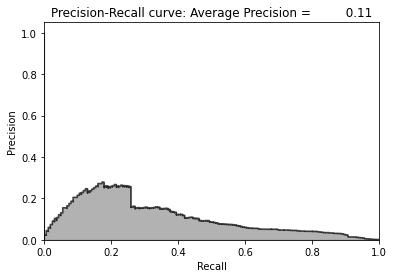

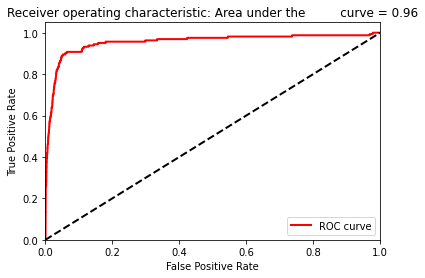

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 16.1786 - accuracy: 0.8961 - val_loss: 0.4363 - val_accuracy: 0.9266
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.7199 - accuracy: 0.9398 - val_loss: 9.3586 - val_accuracy: 0.9536
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.0506 - accuracy: 0.9663 - val_loss: 0.3272 - val_accuracy: 0.9786
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.0115 - accuracy: 0.9686 - val_loss: 0.2124 - val_accuracy: 0.9794
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.8729 - accuracy: 0.9799 - val_loss: 0.0450 - val_accuracy: 0.9860
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.8783 - accuracy: 0.9734 - val_loss: 0.0534 - val_accuracy: 0.9787
Epoch 7/10
5964/5964 [==============================] - 11s 2ms/step - loss: 2.2826 - accuracy: 0.9697 - val_loss: 0.2693 - val_a

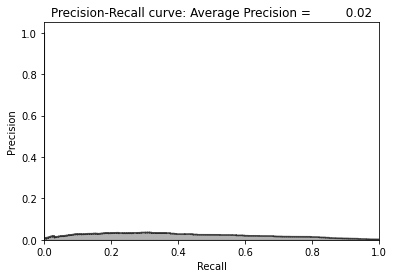

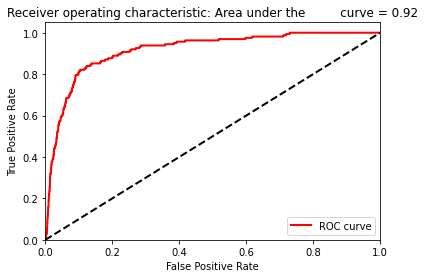

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 18.0741 - accuracy: 0.8951 - val_loss: 0.3873 - val_accuracy: 0.9221
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 2.8266 - accuracy: 0.9307 - val_loss: 6.5771 - val_accuracy: 0.9451
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.4254 - accuracy: 0.9549 - val_loss: 0.2771 - val_accuracy: 0.9698
Epoch 4/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.0497 - accuracy: 0.9681 - val_loss: 0.2428 - val_accuracy: 0.9716
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.0297 - accuracy: 0.9706 - val_loss: 0.0773 - val_accuracy: 0.9815
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.1989 - accuracy: 0.9745 - val_loss: 0.0693 - val_accuracy: 0.9792
Epoch 7/10
5964/5964 [==============================] - 11s 2ms/step - loss: 2.0774 - accuracy: 0.9757 - val_loss: 0.1735 - val_a

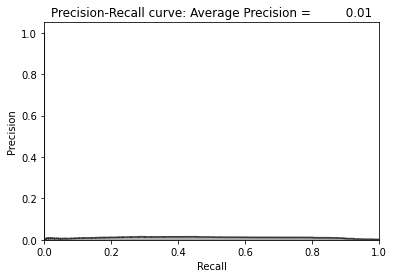

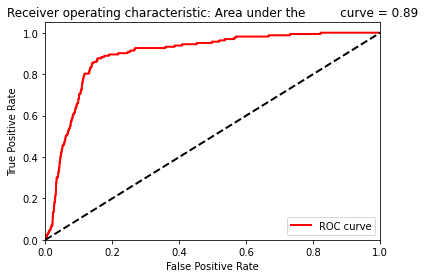

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 18.1240 - accuracy: 0.9019 - val_loss: 0.3534 - val_accuracy: 0.9412
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.9020 - accuracy: 0.9451 - val_loss: 4.4970 - val_accuracy: 0.9575
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.3320 - accuracy: 0.9569 - val_loss: 0.1997 - val_accuracy: 0.9765
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.2393 - accuracy: 0.9671 - val_loss: 0.2901 - val_accuracy: 0.9760
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.9458 - accuracy: 0.9694 - val_loss: 0.0672 - val_accuracy: 0.9809
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.3171 - accuracy: 0.9716 - val_loss: 0.0431 - val_accuracy: 0.9817
Epoch 7/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.5305 - accuracy: 0.9783 - val_loss: 0.1566 - val_a

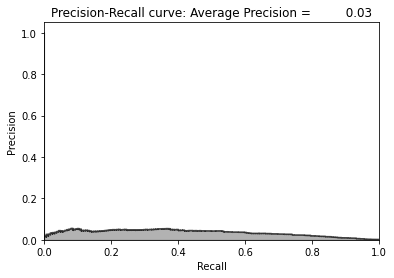

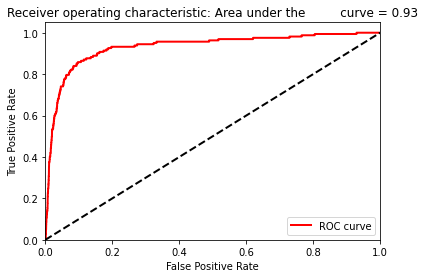

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 13.1007 - accuracy: 0.8894 - val_loss: 0.3853 - val_accuracy: 0.9195
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.8438 - accuracy: 0.9382 - val_loss: 9.4816 - val_accuracy: 0.9571
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.0910 - accuracy: 0.9640 - val_loss: 0.2636 - val_accuracy: 0.9763
Epoch 4/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.0063 - accuracy: 0.9683 - val_loss: 0.2169 - val_accuracy: 0.9793
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.1965 - accuracy: 0.9647 - val_loss: 0.0682 - val_accuracy: 0.9793
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.1155 - accuracy: 0.9740 - val_loss: 0.0413 - val_accuracy: 0.9816
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.6796 - accuracy: 0.9794 - val_loss: 0.1152 - val_a

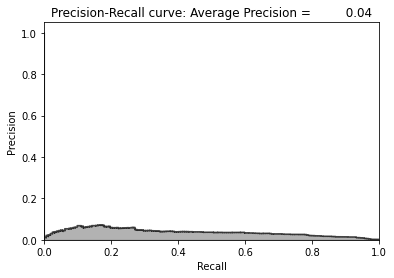

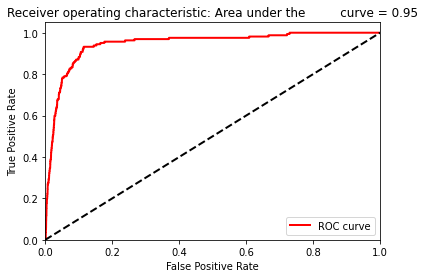

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 9.5338 - accuracy: 0.9002 - val_loss: 0.3624 - val_accuracy: 0.9309
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.9291 - accuracy: 0.9441 - val_loss: 5.3979 - val_accuracy: 0.9590
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.1637 - accuracy: 0.9642 - val_loss: 0.4064 - val_accuracy: 0.9758
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.9455 - accuracy: 0.9704 - val_loss: 0.2684 - val_accuracy: 0.9671
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.7332 - accuracy: 0.9704 - val_loss: 0.0809 - val_accuracy: 0.9719
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.9904 - accuracy: 0.9701 - val_loss: 0.0759 - val_accuracy: 0.9777
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 2.4794 - accuracy: 0.9707 - val_loss: 0.2411 - val_ac

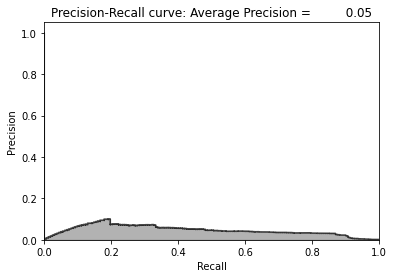

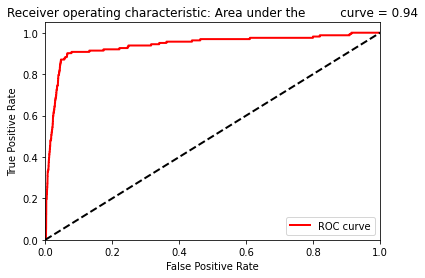

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 15.1694 - accuracy: 0.8826 - val_loss: 0.3702 - val_accuracy: 0.9111
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.8874 - accuracy: 0.9374 - val_loss: 5.7149 - val_accuracy: 0.9596
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.9979 - accuracy: 0.9663 - val_loss: 0.6463 - val_accuracy: 0.9762
Epoch 4/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.8517 - accuracy: 0.9711 - val_loss: 0.1830 - val_accuracy: 0.9806
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.8626 - accuracy: 0.9689 - val_loss: 0.1232 - val_accuracy: 0.9830
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.8786 - accuracy: 0.9696 - val_loss: 0.0577 - val_accuracy: 0.9800
Epoch 7/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.8080 - accuracy: 0.9764 - val_loss: 0.0983 - val_a

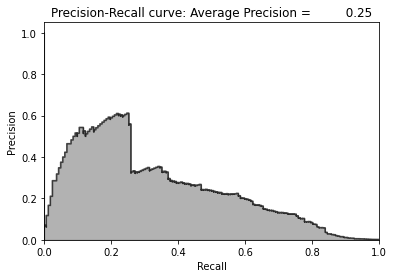

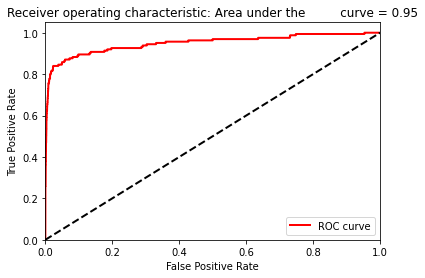

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 25.9301 - accuracy: 0.8847 - val_loss: 0.4452 - val_accuracy: 0.9238
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 1.1914 - accuracy: 0.9305 - val_loss: 4.6555 - val_accuracy: 0.9414
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.1412 - accuracy: 0.9520 - val_loss: 0.4359 - val_accuracy: 0.9716
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.0047 - accuracy: 0.9673 - val_loss: 0.2793 - val_accuracy: 0.9760
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.8539 - accuracy: 0.9691 - val_loss: 0.0735 - val_accuracy: 0.9804
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.7572 - accuracy: 0.9764 - val_loss: 0.0548 - val_accuracy: 0.9817
Epoch 7/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.7330 - accuracy: 0.9764 - val_loss: 0.1963 - val_a

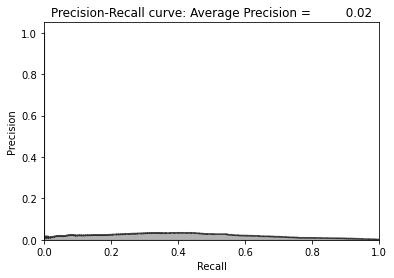

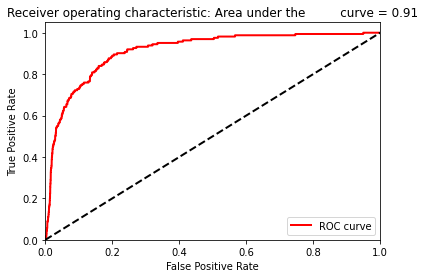

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 17.5291 - accuracy: 0.9051 - val_loss: 0.4068 - val_accuracy: 0.9370
Epoch 2/10
5964/5964 [==============================] - 15s 2ms/step - loss: 1.8395 - accuracy: 0.9448 - val_loss: 3.8339 - val_accuracy: 0.9621
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 3.0691 - accuracy: 0.9504 - val_loss: 0.4574 - val_accuracy: 0.9671
Epoch 4/10
5964/5964 [==============================] - 14s 2ms/step - loss: 1.1950 - accuracy: 0.9660 - val_loss: 0.3431 - val_accuracy: 0.9754
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.1790 - accuracy: 0.9621 - val_loss: 0.0821 - val_accuracy: 0.9776
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.9925 - accuracy: 0.9684 - val_loss: 0.0587 - val_accuracy: 0.9748
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 3.1416 - accuracy: 0.9749 - val_loss: 0.2527 - val_a

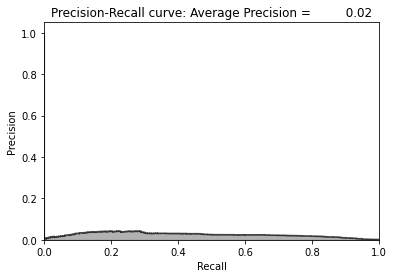

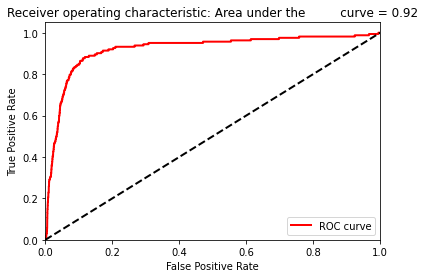

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 14.6722 - accuracy: 0.8847 - val_loss: 0.4235 - val_accuracy: 0.9155
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 2.4139 - accuracy: 0.9262 - val_loss: 4.2794 - val_accuracy: 0.9440
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.2165 - accuracy: 0.9576 - val_loss: 0.5188 - val_accuracy: 0.9738
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.9690 - accuracy: 0.9718 - val_loss: 0.2057 - val_accuracy: 0.9803
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.1141 - accuracy: 0.9699 - val_loss: 0.1385 - val_accuracy: 0.9680
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.6476 - accuracy: 0.9692 - val_loss: 0.0686 - val_accuracy: 0.9838
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.8363 - accuracy: 0.9746 - val_loss: 0.1076 - val_a

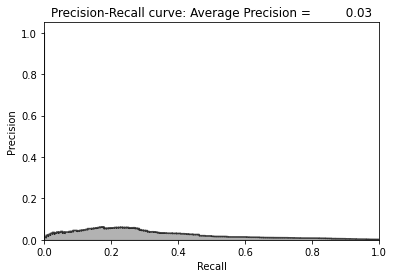

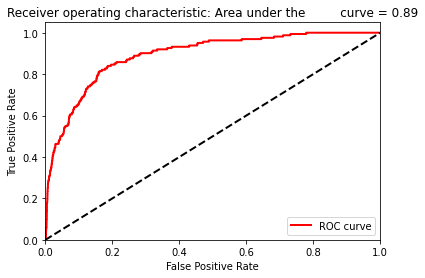

Mean average precision over 10 runs: 0.0577


[0.1064, 0.0213, 0.0111, 0.0345, 0.0366, 0.0462, 0.251, 0.0204, 0.0246, 0.0254]

In [9]:
#Three layer undercomplete autoencoder with linear activation - 28 & 27 nodes respectively
# 10 runs - We will capture mean of average precision
tf.random.set_seed(42)
np.random.seed(42)
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 28 nodes
    model.add(Dense(units=28, activation='linear',input_dim=29))
    model.add(Dense(units=27, activation='linear'))

    # Apply linear activation function to second hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [10]:
#Results three layers, 28->27 nodes
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0577
Coefficient of variation over 10 runs: 1.1984


[0.1064, 0.0213, 0.0111, 0.0345, 0.0366, 0.0462, 0.251, 0.0204, 0.0246, 0.0254]

Epoch 1/10
5964/5964 [==============================] - 15s 2ms/step - loss: 14.3268 - accuracy: 0.9127 - val_loss: 0.8894 - val_accuracy: 0.9245
Epoch 2/10
5964/5964 [==============================] - 15s 3ms/step - loss: 1.3170 - accuracy: 0.9278 - val_loss: 0.8870 - val_accuracy: 0.9270
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 1.6980 - accuracy: 0.9317 - val_loss: 0.9186 - val_accuracy: 0.9386
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.3631 - accuracy: 0.9331 - val_loss: 0.8588 - val_accuracy: 0.9348
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.4667 - accuracy: 0.9319 - val_loss: 0.8722 - val_accuracy: 0.9361
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.9342 - accuracy: 0.9299 - val_loss: 0.8453 - val_accuracy: 0.9331
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 4.4729 - accuracy: 0.9345 - val_loss: 0.8735 - val_a

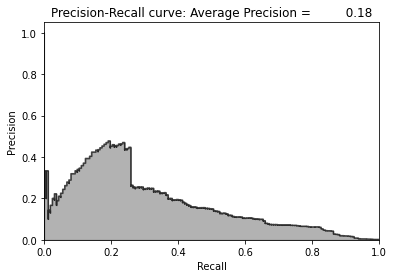

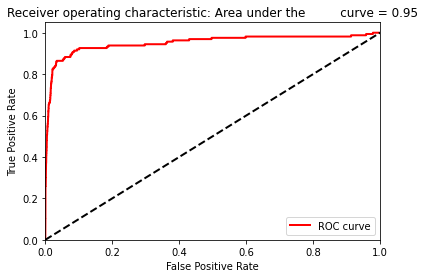

Epoch 1/10
5964/5964 [==============================] - 16s 3ms/step - loss: 36.1816 - accuracy: 0.8933 - val_loss: 0.8965 - val_accuracy: 0.9317
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.4850 - accuracy: 0.9326 - val_loss: 0.8473 - val_accuracy: 0.9360
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.2012 - accuracy: 0.9384 - val_loss: 0.8625 - val_accuracy: 0.9458
Epoch 4/10
5964/5964 [==============================] - 17s 3ms/step - loss: 1.2979 - accuracy: 0.9422 - val_loss: 0.8596 - val_accuracy: 0.9410
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.6511 - accuracy: 0.9393 - val_loss: 1.1937 - val_accuracy: 0.9460
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.8748 - accuracy: 0.9378 - val_loss: 0.8404 - val_accuracy: 0.9403
Epoch 7/10
5964/5964 [==============================] - 14s 2ms/step - loss: 1.3584 - accuracy: 0.9364 - val_loss: 0.8510 - val_a

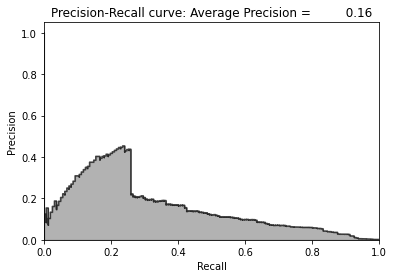

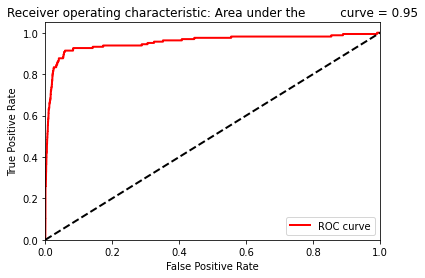

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 15.3753 - accuracy: 0.9147 - val_loss: 0.8872 - val_accuracy: 0.9287
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.1279 - accuracy: 0.9287 - val_loss: 0.8849 - val_accuracy: 0.9352
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.2457 - accuracy: 0.9362 - val_loss: 0.8576 - val_accuracy: 0.9382
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.2473 - accuracy: 0.9389 - val_loss: 0.8491 - val_accuracy: 0.9372
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.2359 - accuracy: 0.9392 - val_loss: 2.2608 - val_accuracy: 0.9456
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.6135 - accuracy: 0.9379 - val_loss: 0.8188 - val_accuracy: 0.9462
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.6892 - accuracy: 0.9397 - val_loss: 0.8557 - val_a

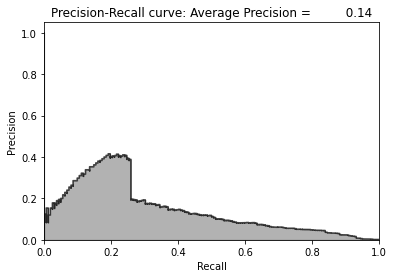

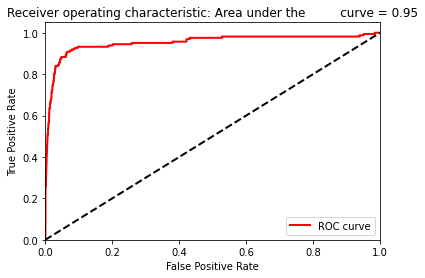

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 20.2863 - accuracy: 0.8757 - val_loss: 1.1111 - val_accuracy: 0.8870
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 1.3688 - accuracy: 0.9034 - val_loss: 1.3917 - val_accuracy: 0.9104
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 1.4767 - accuracy: 0.9150 - val_loss: 0.8518 - val_accuracy: 0.9167
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.1740 - accuracy: 0.9163 - val_loss: 0.8446 - val_accuracy: 0.9198
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.2086 - accuracy: 0.9177 - val_loss: 0.8129 - val_accuracy: 0.9231
Epoch 6/10
5964/5964 [==============================] - 14s 2ms/step - loss: 2.7974 - accuracy: 0.9152 - val_loss: 0.8377 - val_accuracy: 0.9104
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 2.7633 - accuracy: 0.9157 - val_loss: 0.8634 - val_a

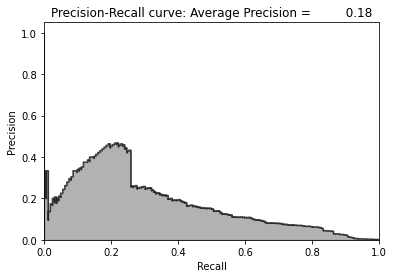

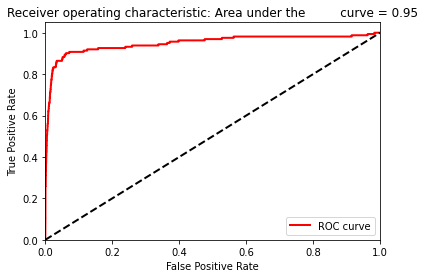

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 16.9169 - accuracy: 0.9110 - val_loss: 0.9389 - val_accuracy: 0.9355
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.2502 - accuracy: 0.9329 - val_loss: 4.2255 - val_accuracy: 0.9430
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 2.0726 - accuracy: 0.9366 - val_loss: 0.8712 - val_accuracy: 0.9394
Epoch 4/10
5964/5964 [==============================] - 14s 2ms/step - loss: 1.1816 - accuracy: 0.9372 - val_loss: 0.8918 - val_accuracy: 0.9478
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.5222 - accuracy: 0.9290 - val_loss: 0.8972 - val_accuracy: 0.9409
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.1742 - accuracy: 0.9363 - val_loss: 0.8661 - val_accuracy: 0.9273
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 3.4308 - accuracy: 0.9339 - val_loss: 0.8969 - val_a

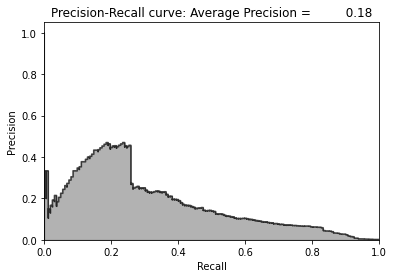

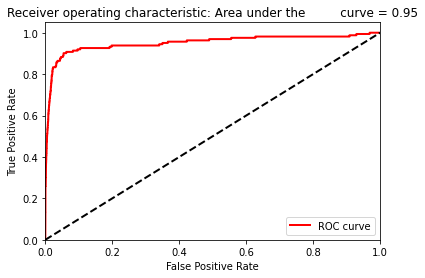

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 16.2214 - accuracy: 0.9076 - val_loss: 0.9208 - val_accuracy: 0.9257
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.3650 - accuracy: 0.9280 - val_loss: 0.8496 - val_accuracy: 0.9341
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.3803 - accuracy: 0.9369 - val_loss: 0.8258 - val_accuracy: 0.9472
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.3861 - accuracy: 0.9400 - val_loss: 0.8650 - val_accuracy: 0.9393
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.2931 - accuracy: 0.9379 - val_loss: 0.8912 - val_accuracy: 0.9173
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.3082 - accuracy: 0.9315 - val_loss: 0.8552 - val_accuracy: 0.9323
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 2.8390 - accuracy: 0.9259 - val_loss: 0.8957 - val_a

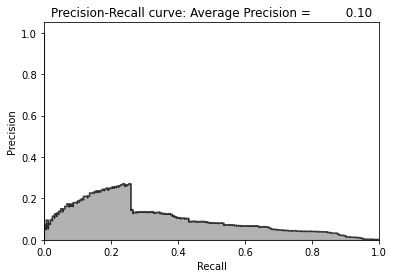

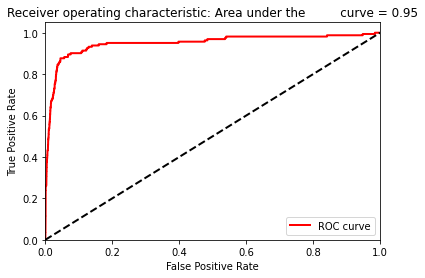

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 17.9548 - accuracy: 0.8826 - val_loss: 0.9623 - val_accuracy: 0.8952
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.8252 - accuracy: 0.8974 - val_loss: 1.1397 - val_accuracy: 0.9017
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.5591 - accuracy: 0.9001 - val_loss: 0.9945 - val_accuracy: 0.9035
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.5492 - accuracy: 0.9029 - val_loss: 0.8897 - val_accuracy: 0.9012
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.2321 - accuracy: 0.9016 - val_loss: 0.8724 - val_accuracy: 0.9042
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 2.2327 - accuracy: 0.8999 - val_loss: 0.8860 - val_accuracy: 0.9008
Epoch 7/10
5964/5964 [==============================] - 14s 2ms/step - loss: 2.3555 - accuracy: 0.8990 - val_loss: 0.9637 - val_a

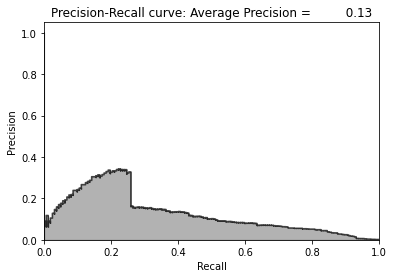

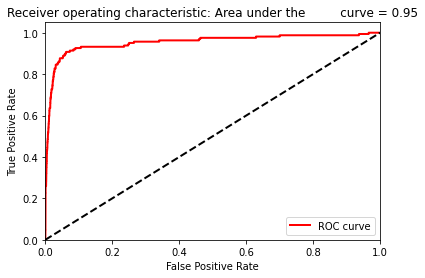

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 47.9083 - accuracy: 0.8915 - val_loss: 1.0388 - val_accuracy: 0.9090
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.2477 - accuracy: 0.9348 - val_loss: 1.4416 - val_accuracy: 0.9289
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.2767 - accuracy: 0.9390 - val_loss: 0.8346 - val_accuracy: 0.9417
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.1523 - accuracy: 0.9413 - val_loss: 0.8736 - val_accuracy: 0.9262
Epoch 5/10
5964/5964 [==============================] - 15s 2ms/step - loss: 1.3498 - accuracy: 0.9456 - val_loss: 0.8977 - val_accuracy: 0.9454
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.1628 - accuracy: 0.9438 - val_loss: 0.8298 - val_accuracy: 0.9411
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.1526 - accuracy: 0.9433 - val_loss: 0.7590 - val_a

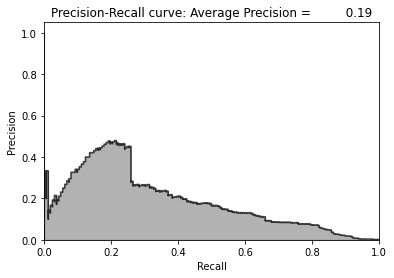

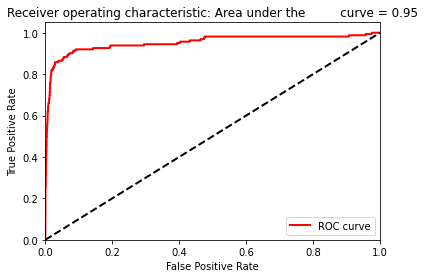

Epoch 1/10
5964/5964 [==============================] - 15s 2ms/step - loss: 12.0492 - accuracy: 0.8999 - val_loss: 0.9180 - val_accuracy: 0.9292
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 1.4064 - accuracy: 0.9299 - val_loss: 0.8940 - val_accuracy: 0.9374
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.9019 - accuracy: 0.9374 - val_loss: 0.9018 - val_accuracy: 0.9414
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.4543 - accuracy: 0.9455 - val_loss: 0.8549 - val_accuracy: 0.9516
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.4646 - accuracy: 0.9483 - val_loss: 0.8096 - val_accuracy: 0.9531
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.3527 - accuracy: 0.9492 - val_loss: 0.8236 - val_accuracy: 0.9535
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 3.1760 - accuracy: 0.9493 - val_loss: 0.8167 - val_a

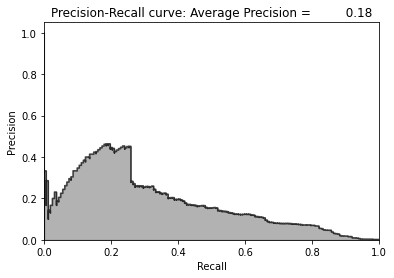

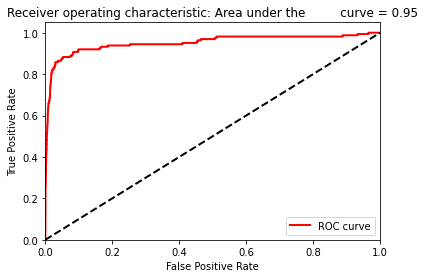

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 13.7451 - accuracy: 0.9041 - val_loss: 0.9285 - val_accuracy: 0.9253
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.1997 - accuracy: 0.9238 - val_loss: 1.5707 - val_accuracy: 0.9216
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.3655 - accuracy: 0.9254 - val_loss: 0.9529 - val_accuracy: 0.9191
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.2380 - accuracy: 0.9258 - val_loss: 0.9547 - val_accuracy: 0.9185
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.1821 - accuracy: 0.9296 - val_loss: 0.8634 - val_accuracy: 0.9344
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.7012 - accuracy: 0.9298 - val_loss: 0.8628 - val_accuracy: 0.9294
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.1731 - accuracy: 0.9327 - val_loss: 0.8306 - val_a

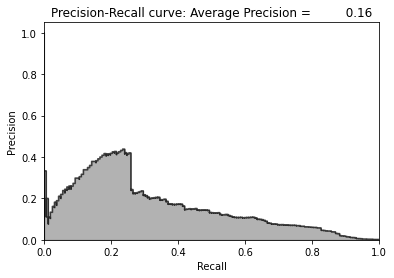

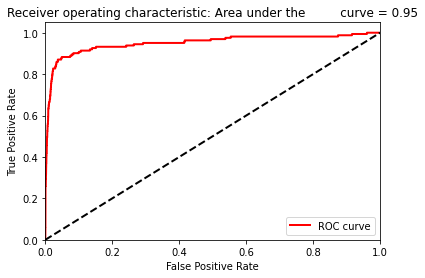

Mean average precision over 10 runs: 0.1585


[0.1766, 0.156, 0.1442, 0.1757, 0.1757, 0.1014, 0.126, 0.1873, 0.1807, 0.1613]

In [11]:
#Nonlinear autoencoder
#Four layer undercomplete autoencoder with ReLu activation
#29 -> 27 -> 22 -> 27 -> 29 Nodes
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply ReLu throughout
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 22 nodes
    model.add(Dense(units=27, activation='relu',input_dim=29))
    model.add(Dense(units=22, activation='relu'))

    # Apply ReLu throughout
    # Generate third hidden layer with 27 nodes
    # Generate output layer with 29 nodes
    model.add(Dense(units=27, activation='relu'))
    model.add(Dense(units=29, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]


In [12]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.1585
Coefficient of variation over 10 runs: 0.1641


[0.1766, 0.156, 0.1442, 0.1757, 0.1757, 0.1014, 0.126, 0.1873, 0.1807, 0.1613]

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 34.1496 - accuracy: 0.9061 - val_loss: 0.1258 - val_accuracy: 0.9693
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.2908 - accuracy: 0.9806 - val_loss: 2.1828 - val_accuracy: 0.9925
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7951 - accuracy: 0.9908 - val_loss: 0.1862 - val_accuracy: 0.9963
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5593 - accuracy: 0.9918 - val_loss: 0.0482 - val_accuracy: 0.9892
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.4917 - accuracy: 0.9902 - val_loss: 0.0077 - val_accuracy: 0.9964
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.7258 - accuracy: 0.9888 - val_loss: 0.0030 - val_accuracy: 0.9950
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.7151 - accuracy: 0.9859 - val_loss: 0.0990 - val_a

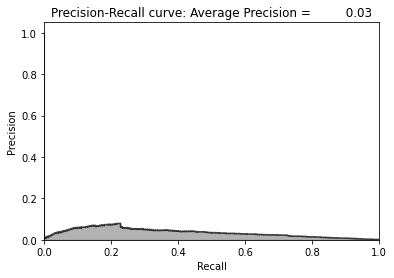

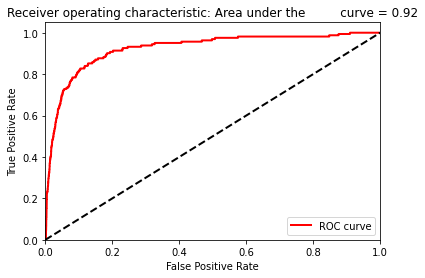

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 27.2318 - accuracy: 0.9104 - val_loss: 0.1171 - val_accuracy: 0.9634
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 1.8880 - accuracy: 0.9789 - val_loss: 8.4333 - val_accuracy: 0.9895
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.9328 - accuracy: 0.9907 - val_loss: 0.1261 - val_accuracy: 0.9966
Epoch 4/10
5964/5964 [==============================] - 15s 3ms/step - loss: 0.6887 - accuracy: 0.9907 - val_loss: 0.0375 - val_accuracy: 0.9914
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.7065 - accuracy: 0.9919 - val_loss: 0.0117 - val_accuracy: 0.9944
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.6971 - accuracy: 0.9896 - val_loss: 0.0041 - val_accuracy: 0.9953
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 2.8571 - accuracy: 0.9881 - val_loss: 0.1080 - val_a

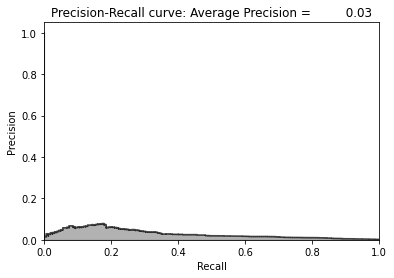

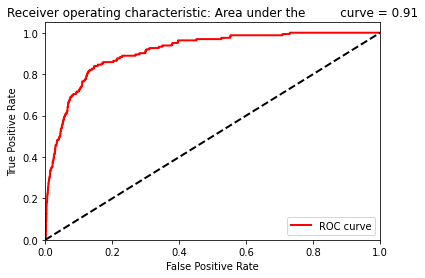

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 38.6456 - accuracy: 0.9157 - val_loss: 0.1523 - val_accuracy: 0.9659
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.2658 - accuracy: 0.9828 - val_loss: 6.7126 - val_accuracy: 0.9923
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.9189 - accuracy: 0.9898 - val_loss: 0.2093 - val_accuracy: 0.9964
Epoch 4/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.6157 - accuracy: 0.9914 - val_loss: 0.0527 - val_accuracy: 0.9935
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.4919 - accuracy: 0.9909 - val_loss: 0.0032 - val_accuracy: 0.9967
Epoch 6/10
5964/5964 [==============================] - 15s 3ms/step - loss: 0.7993 - accuracy: 0.9891 - val_loss: 0.0042 - val_accuracy: 0.9960
Epoch 7/10
5964/5964 [==============================] - 14s 2ms/step - loss: 2.1846 - accuracy: 0.9904 - val_loss: 0.1004 - val_a

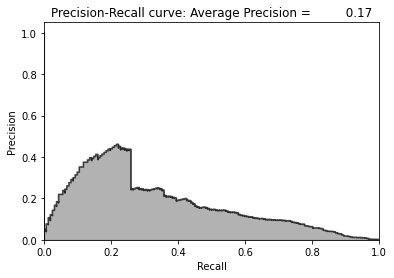

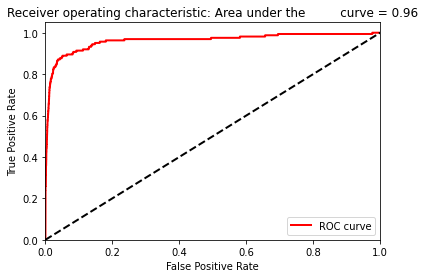

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 11.4654 - accuracy: 0.9318 - val_loss: 0.1037 - val_accuracy: 0.9764
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.2190 - accuracy: 0.9844 - val_loss: 8.2135 - val_accuracy: 0.9912
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.6513 - accuracy: 0.9905 - val_loss: 0.0398 - val_accuracy: 0.9963
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.5317 - accuracy: 0.9894 - val_loss: 0.0503 - val_accuracy: 0.9933
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.5515 - accuracy: 0.9891 - val_loss: 0.0115 - val_accuracy: 0.9958
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.0357 - accuracy: 0.9883 - val_loss: 0.0041 - val_accuracy: 0.9943
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 2.1142 - accuracy: 0.9882 - val_loss: 0.0915 - val_a

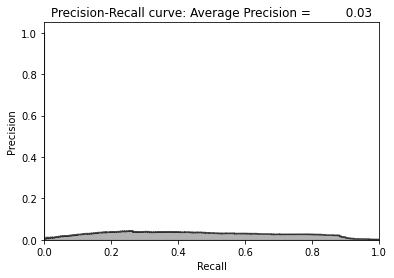

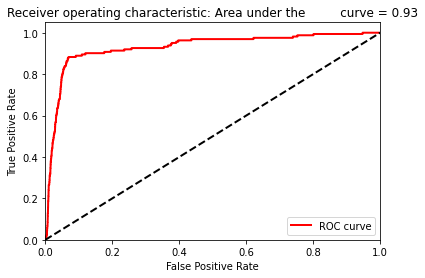

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 37.7042 - accuracy: 0.9113 - val_loss: 0.1248 - val_accuracy: 0.9523
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.2810 - accuracy: 0.9802 - val_loss: 3.4468 - val_accuracy: 0.9921
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7987 - accuracy: 0.9909 - val_loss: 0.2911 - val_accuracy: 0.9961
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5276 - accuracy: 0.9908 - val_loss: 0.0566 - val_accuracy: 0.9884
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.4517 - accuracy: 0.9913 - val_loss: 0.0091 - val_accuracy: 0.9967
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.6192 - accuracy: 0.9902 - val_loss: 0.0040 - val_accuracy: 0.9951
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.0461 - accuracy: 0.9876 - val_loss: 0.0650 - val_a

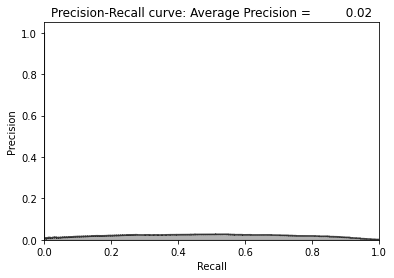

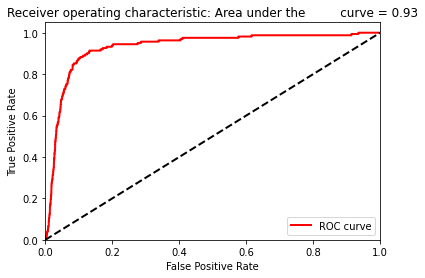

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 22.3629 - accuracy: 0.9226 - val_loss: 0.1172 - val_accuracy: 0.9645
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.4943 - accuracy: 0.9817 - val_loss: 2.9022 - val_accuracy: 0.9921
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.1283 - accuracy: 0.9878 - val_loss: 0.1114 - val_accuracy: 0.9965
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.6717 - accuracy: 0.9901 - val_loss: 0.0398 - val_accuracy: 0.9928
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5940 - accuracy: 0.9910 - val_loss: 0.0153 - val_accuracy: 0.9886
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7927 - accuracy: 0.9906 - val_loss: 0.0014 - val_accuracy: 0.9972
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 2.0465 - accuracy: 0.9895 - val_loss: 0.1108 - val_a

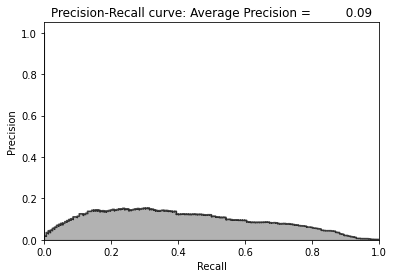

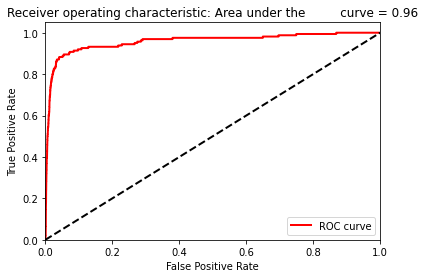

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 37.2889 - accuracy: 0.9021 - val_loss: 0.1492 - val_accuracy: 0.9552
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.5590 - accuracy: 0.9730 - val_loss: 3.4409 - val_accuracy: 0.9851
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.8621 - accuracy: 0.9877 - val_loss: 0.1136 - val_accuracy: 0.9955
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5740 - accuracy: 0.9903 - val_loss: 0.0491 - val_accuracy: 0.9932
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5289 - accuracy: 0.9904 - val_loss: 0.0021 - val_accuracy: 0.9967
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.8178 - accuracy: 0.9882 - val_loss: 0.0034 - val_accuracy: 0.9959
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.0009 - accuracy: 0.9924 - val_loss: 0.0395 - val_a

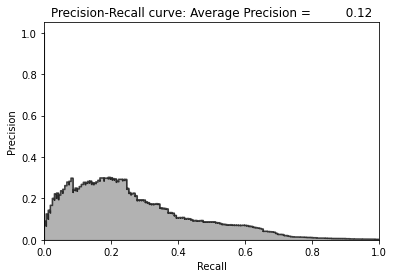

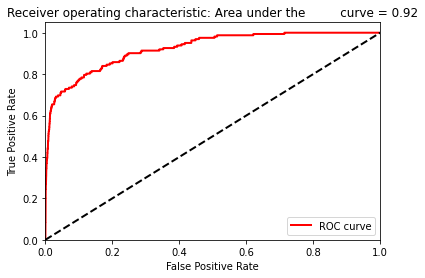

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 23.3048 - accuracy: 0.9172 - val_loss: 0.1054 - val_accuracy: 0.9676
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.2691 - accuracy: 0.9850 - val_loss: 5.6952 - val_accuracy: 0.9926
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5941 - accuracy: 0.9920 - val_loss: 0.0867 - val_accuracy: 0.9974
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.5006 - accuracy: 0.9915 - val_loss: 0.0523 - val_accuracy: 0.9896
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.4503 - accuracy: 0.9918 - val_loss: 0.0037 - val_accuracy: 0.9977
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7825 - accuracy: 0.9896 - val_loss: 0.0017 - val_accuracy: 0.9964
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.6311 - accuracy: 0.9898 - val_loss: 0.0615 - val_a

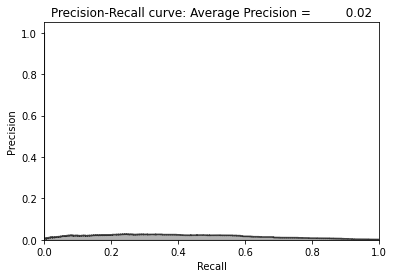

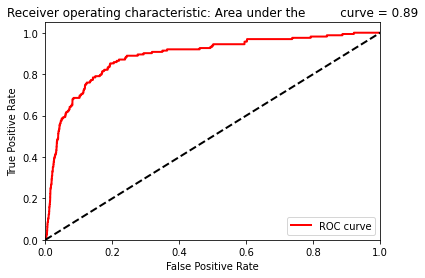

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 20.0244 - accuracy: 0.9323 - val_loss: 0.1176 - val_accuracy: 0.9711
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.7283 - accuracy: 0.9826 - val_loss: 2.1351 - val_accuracy: 0.9900
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.1893 - accuracy: 0.9891 - val_loss: 0.3432 - val_accuracy: 0.9947
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7301 - accuracy: 0.9903 - val_loss: 0.0364 - val_accuracy: 0.9891
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.6766 - accuracy: 0.9912 - val_loss: 0.0077 - val_accuracy: 0.9959
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7595 - accuracy: 0.9910 - val_loss: 0.0037 - val_accuracy: 0.9953
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 2.0242 - accuracy: 0.9874 - val_loss: 0.1484 - val_a

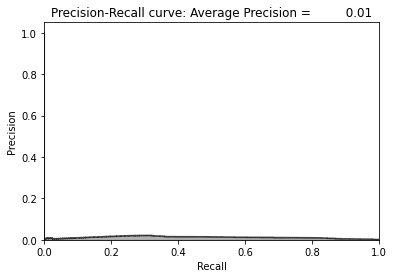

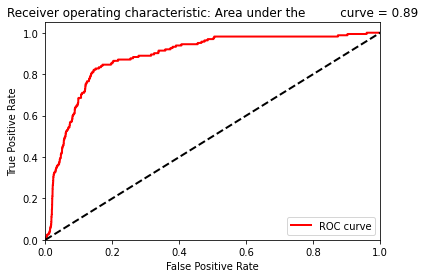

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 25.7351 - accuracy: 0.9146 - val_loss: 0.1083 - val_accuracy: 0.9662
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.5943 - accuracy: 0.9805 - val_loss: 4.7578 - val_accuracy: 0.9908
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.8893 - accuracy: 0.9900 - val_loss: 0.1638 - val_accuracy: 0.9955
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7320 - accuracy: 0.9910 - val_loss: 0.0611 - val_accuracy: 0.9886
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5214 - accuracy: 0.9911 - val_loss: 0.0024 - val_accuracy: 0.9965
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.8517 - accuracy: 0.9887 - val_loss: 0.0034 - val_accuracy: 0.9956
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 2.2382 - accuracy: 0.9909 - val_loss: 0.0805 - val_a

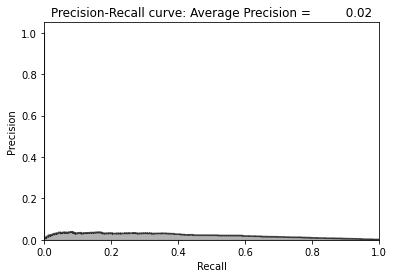

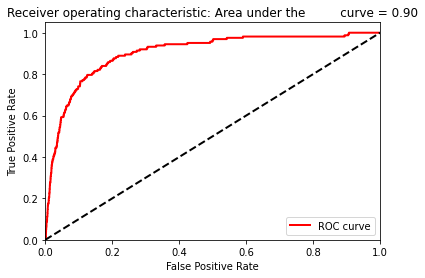

Mean average precision over 10 runs: 0.0543


[0.0346, 0.0283, 0.1737, 0.0276, 0.0197, 0.0935, 0.1156, 0.0169, 0.012, 0.0212]

In [13]:
# Two layer overcomplete autoencode with linear activiation 29-> 40 -> 29 

tf.random.set_seed(42)
np.random.seed(42)
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function throughout
    # Generate first hidden layer with 40 nodes
    model.add(Dense(units=40, activation='linear',input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [14]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0543
Coefficient of variation over 10 runs: 0.953


[0.0346, 0.0283, 0.1737, 0.0276, 0.0197, 0.0935, 0.1156, 0.0169, 0.012, 0.0212]

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 133.2602 - accuracy: 0.8588 - val_loss: 1.4895 - val_accuracy: 0.8952
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 22.5529 - accuracy: 0.8976 - val_loss: 60.2832 - val_accuracy: 0.9117
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 16.1674 - accuracy: 0.8778 - val_loss: 1.4061 - val_accuracy: 0.8831
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 16.8727 - accuracy: 0.8744 - val_loss: 5.2370 - val_accuracy: 0.8621
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.8146 - accuracy: 0.8740 - val_loss: 1.2979 - val_accuracy: 0.9075
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 11.6920 - accuracy: 0.8816 - val_loss: 0.9215 - val_accuracy: 0.8802
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.4400 - accuracy: 0.8767 - val_loss: 1.5983

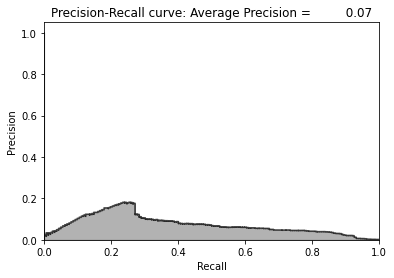

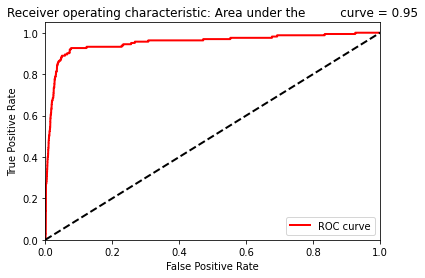

Epoch 1/10
5964/5964 [==============================] - 15s 2ms/step - loss: 82.1018 - accuracy: 0.8698 - val_loss: 1.3368 - val_accuracy: 0.9085
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 17.9150 - accuracy: 0.8948 - val_loss: 52.4829 - val_accuracy: 0.9009
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.5745 - accuracy: 0.8890 - val_loss: 0.7129 - val_accuracy: 0.8914
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 17.0267 - accuracy: 0.8840 - val_loss: 3.5040 - val_accuracy: 0.8917
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.0526 - accuracy: 0.8810 - val_loss: 1.7388 - val_accuracy: 0.9096
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 11.8993 - accuracy: 0.8887 - val_loss: 0.8012 - val_accuracy: 0.8982
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.9351 - accuracy: 0.8897 - val_loss: 1.7690 

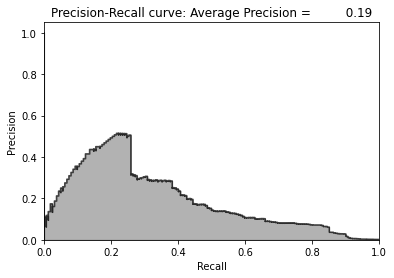

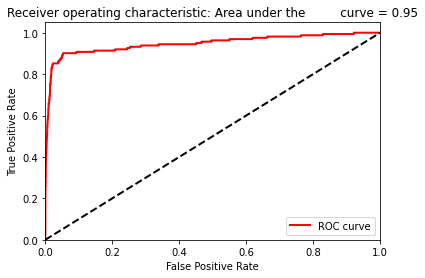

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 87.0939 - accuracy: 0.8656 - val_loss: 1.3152 - val_accuracy: 0.8946
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 18.3153 - accuracy: 0.8919 - val_loss: 35.8336 - val_accuracy: 0.9129
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.6350 - accuracy: 0.8847 - val_loss: 1.0290 - val_accuracy: 0.8742
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 18.3636 - accuracy: 0.8805 - val_loss: 3.4466 - val_accuracy: 0.8980
Epoch 5/10
5964/5964 [==============================] - 14s 2ms/step - loss: 14.3917 - accuracy: 0.8844 - val_loss: 2.4430 - val_accuracy: 0.9151
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 11.7017 - accuracy: 0.8943 - val_loss: 0.8813 - val_accuracy: 0.9057
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 12.8558 - accuracy: 0.8902 - val_loss: 1.3517 

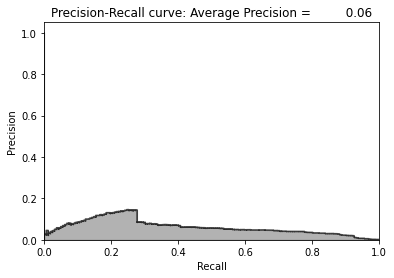

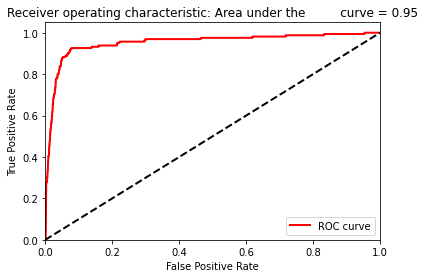

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 80.1775 - accuracy: 0.8651 - val_loss: 1.1351 - val_accuracy: 0.8711
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 18.2155 - accuracy: 0.8865 - val_loss: 8.8937 - val_accuracy: 0.9042
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 13.9235 - accuracy: 0.8792 - val_loss: 1.1431 - val_accuracy: 0.8927
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 17.7019 - accuracy: 0.8788 - val_loss: 4.1510 - val_accuracy: 0.8820
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 12.8609 - accuracy: 0.8764 - val_loss: 1.0945 - val_accuracy: 0.9114
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 10.9141 - accuracy: 0.8893 - val_loss: 0.8401 - val_accuracy: 0.9040
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 13.7270 - accuracy: 0.8867 - val_loss: 1.5710 -

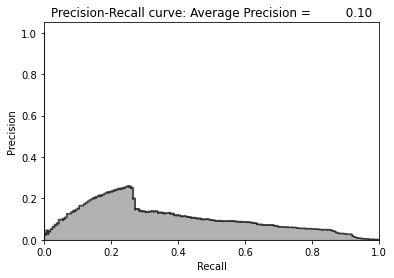

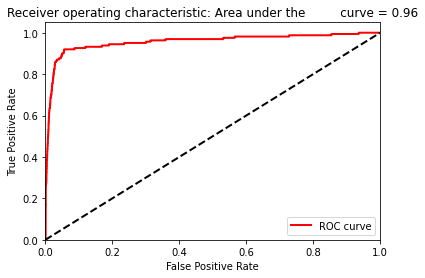

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 91.9549 - accuracy: 0.8599 - val_loss: 1.3842 - val_accuracy: 0.8905
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 20.4085 - accuracy: 0.8791 - val_loss: 14.9524 - val_accuracy: 0.8946
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.7967 - accuracy: 0.8873 - val_loss: 0.8858 - val_accuracy: 0.8971
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 16.7684 - accuracy: 0.8842 - val_loss: 3.5746 - val_accuracy: 0.8697
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 14.7791 - accuracy: 0.8722 - val_loss: 1.4135 - val_accuracy: 0.8939
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 11.3685 - accuracy: 0.8855 - val_loss: 0.8152 - val_accuracy: 0.8939
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 12.8746 - accuracy: 0.8853 - val_loss: 1.3296 

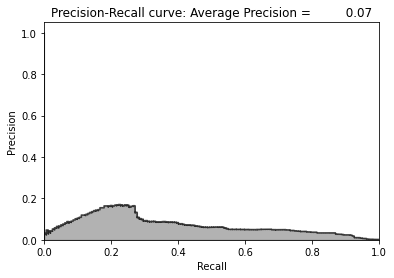

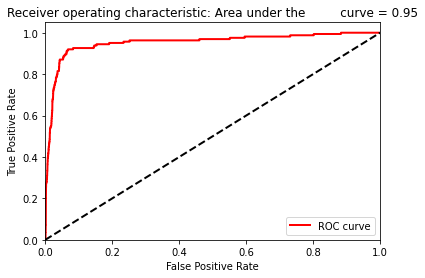

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 102.1568 - accuracy: 0.8643 - val_loss: 1.2442 - val_accuracy: 0.8940
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 19.6725 - accuracy: 0.8944 - val_loss: 13.3334 - val_accuracy: 0.9066
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.7317 - accuracy: 0.8933 - val_loss: 3.1489 - val_accuracy: 0.8884
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 17.4384 - accuracy: 0.8831 - val_loss: 8.1165 - val_accuracy: 0.8805
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.1081 - accuracy: 0.8836 - val_loss: 1.6609 - val_accuracy: 0.9147
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 11.8468 - accuracy: 0.8892 - val_loss: 0.7914 - val_accuracy: 0.8879
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.3866 - accuracy: 0.8863 - val_loss: 1.4607

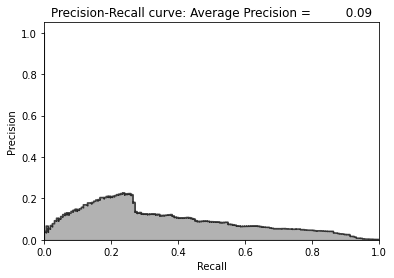

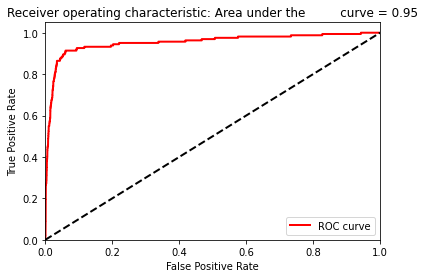

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 93.5772 - accuracy: 0.8784 - val_loss: 1.1353 - val_accuracy: 0.9224
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 20.0104 - accuracy: 0.9003 - val_loss: 47.9609 - val_accuracy: 0.9270
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 16.3092 - accuracy: 0.8841 - val_loss: 1.0425 - val_accuracy: 0.9021
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 18.3585 - accuracy: 0.8814 - val_loss: 5.4735 - val_accuracy: 0.8890
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 12.8704 - accuracy: 0.8828 - val_loss: 1.1373 - val_accuracy: 0.9144
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 11.9641 - accuracy: 0.8913 - val_loss: 0.7118 - val_accuracy: 0.9007
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 14.4320 - accuracy: 0.8893 - val_loss: 1.5106 

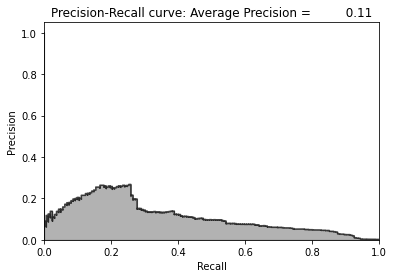

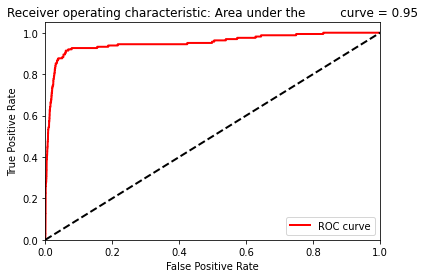

Epoch 1/10
5964/5964 [==============================] - 23s 4ms/step - loss: 88.4771 - accuracy: 0.8692 - val_loss: 1.0735 - val_accuracy: 0.9231
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 17.6566 - accuracy: 0.8992 - val_loss: 14.2214 - val_accuracy: 0.9168
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 13.2956 - accuracy: 0.8885 - val_loss: 2.9093 - val_accuracy: 0.9038
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 17.2795 - accuracy: 0.8823 - val_loss: 7.8738 - val_accuracy: 0.8766
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 14.0047 - accuracy: 0.8830 - val_loss: 0.9268 - val_accuracy: 0.9157
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 11.7327 - accuracy: 0.8951 - val_loss: 0.9204 - val_accuracy: 0.9081
Epoch 7/10
5964/5964 [==============================] - 22s 4ms/step - loss: 14.3496 - accuracy: 0.8912 - val_loss: 1.3814 

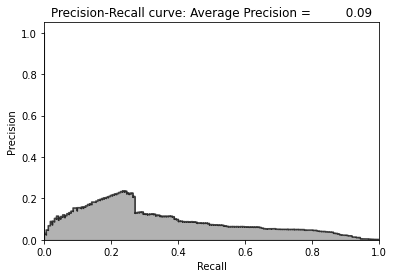

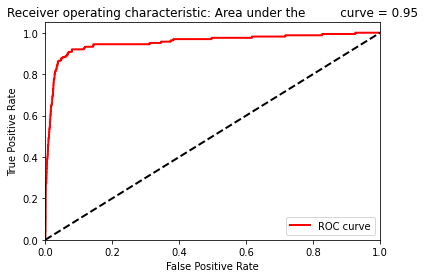

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 115.0823 - accuracy: 0.8623 - val_loss: 1.6398 - val_accuracy: 0.8843
Epoch 2/10
5964/5964 [==============================] - 22s 4ms/step - loss: 20.0000 - accuracy: 0.8866 - val_loss: 20.8335 - val_accuracy: 0.9019
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 13.6633 - accuracy: 0.8936 - val_loss: 0.9467 - val_accuracy: 0.8912
Epoch 4/10
5964/5964 [==============================] - 22s 4ms/step - loss: 16.8203 - accuracy: 0.8869 - val_loss: 1.7448 - val_accuracy: 0.8826
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 15.2881 - accuracy: 0.8783 - val_loss: 1.6984 - val_accuracy: 0.8978
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 12.5499 - accuracy: 0.8871 - val_loss: 0.7715 - val_accuracy: 0.8848
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 13.1866 - accuracy: 0.8825 - val_loss: 1.3364

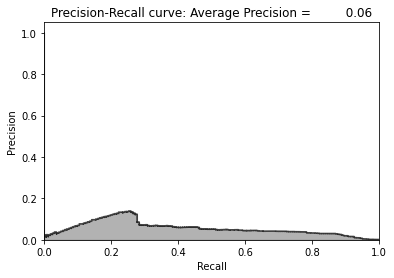

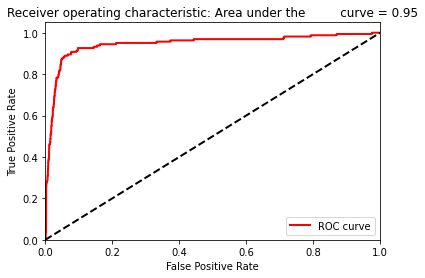

Epoch 1/10
5964/5964 [==============================] - 23s 4ms/step - loss: 114.7815 - accuracy: 0.8636 - val_loss: 1.5490 - val_accuracy: 0.8913
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 21.5344 - accuracy: 0.9080 - val_loss: 19.3852 - val_accuracy: 0.9152
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 16.5390 - accuracy: 0.8836 - val_loss: 1.0949 - val_accuracy: 0.8773
Epoch 4/10
5964/5964 [==============================] - 22s 4ms/step - loss: 17.8053 - accuracy: 0.8819 - val_loss: 2.3648 - val_accuracy: 0.8843
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 14.0014 - accuracy: 0.8821 - val_loss: 1.2576 - val_accuracy: 0.9036
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 11.2859 - accuracy: 0.8814 - val_loss: 0.9713 - val_accuracy: 0.8807
Epoch 7/10
5964/5964 [==============================] - 22s 4ms/step - loss: 13.2743 - accuracy: 0.8785 - val_loss: 1.3463

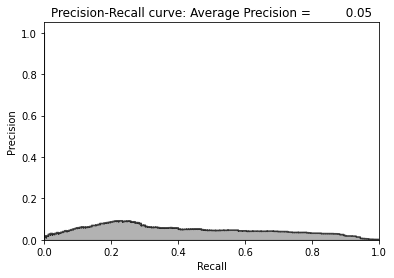

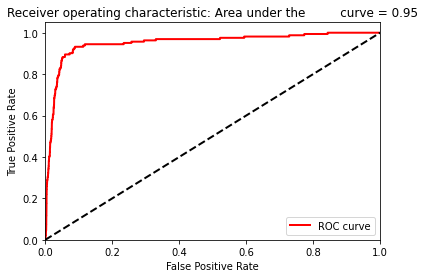

Mean average precision over 10 runs: 0.0898


[0.073, 0.1927, 0.0614, 0.1026, 0.0706, 0.0937, 0.1113, 0.0908, 0.0553, 0.0469]

In [15]:
# Two layer overcomplete autoencoder with linear activation and dropout
# 29 -> 40 -> 29
# Dropout percentage: 10%
#Dropout randomly selects the dropoutpercentage to remove specific nodes during training to avoid overfitting
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',input_dim=29))
    model.add(Dropout(0.10))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [16]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0898
Coefficient of variation over 10 runs: 0.4415


[0.073, 0.1927, 0.0614, 0.1026, 0.0706, 0.0937, 0.1113, 0.0908, 0.0553, 0.0469]

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 22.5572 - accuracy: 0.9226 - val_loss: 0.1629 - val_accuracy: 0.9690
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.6834 - accuracy: 0.9817 - val_loss: 5.9583 - val_accuracy: 0.9918
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.9528 - accuracy: 0.9900 - val_loss: 0.4288 - val_accuracy: 0.9946
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.7310 - accuracy: 0.9913 - val_loss: 0.0819 - val_accuracy: 0.9947
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.7082 - accuracy: 0.9892 - val_loss: 0.0333 - val_accuracy: 0.9893
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 0.8708 - accuracy: 0.9882 - val_loss: 0.0298 - val_accuracy: 0.9954
Epoch 7/10
5964/5964 [==============================] - 15s 3ms/step - loss: 2.1771 - accuracy: 0.9890 - val_loss: 0.1028 - val_a

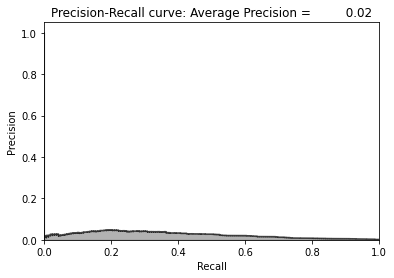

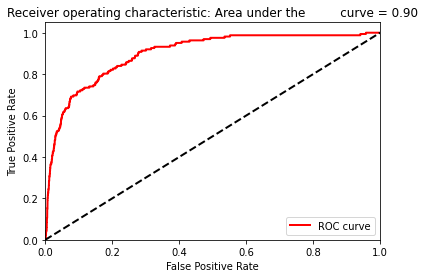

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 35.3379 - accuracy: 0.9039 - val_loss: 0.1868 - val_accuracy: 0.9510
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.2725 - accuracy: 0.9754 - val_loss: 2.0369 - val_accuracy: 0.9918
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 1.0502 - accuracy: 0.9889 - val_loss: 0.0686 - val_accuracy: 0.9970
Epoch 4/10
5964/5964 [==============================] - 15s 2ms/step - loss: 0.5832 - accuracy: 0.9922 - val_loss: 0.0585 - val_accuracy: 0.9926
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.5081 - accuracy: 0.9906 - val_loss: 0.0299 - val_accuracy: 0.9963
Epoch 6/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.5390 - accuracy: 0.9903 - val_loss: 0.0252 - val_accuracy: 0.9954
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.4407 - accuracy: 0.9893 - val_loss: 0.0799 - val_a

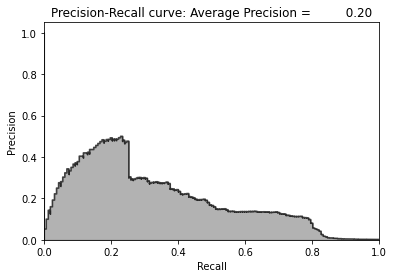

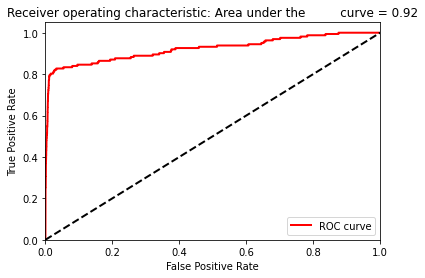

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 23.2674 - accuracy: 0.9210 - val_loss: 0.1529 - val_accuracy: 0.9702
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 1.4106 - accuracy: 0.9827 - val_loss: 2.6192 - val_accuracy: 0.9917
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.9338 - accuracy: 0.9878 - val_loss: 0.1588 - val_accuracy: 0.9967
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5859 - accuracy: 0.9917 - val_loss: 0.0660 - val_accuracy: 0.9909
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.5110 - accuracy: 0.9909 - val_loss: 0.0286 - val_accuracy: 0.9964
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.8371 - accuracy: 0.9890 - val_loss: 0.0276 - val_accuracy: 0.9964
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.8913 - accuracy: 0.9901 - val_loss: 0.1148 - val_a

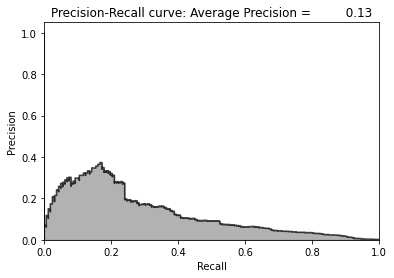

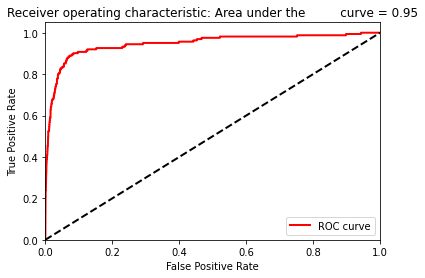

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 39.5810 - accuracy: 0.9105 - val_loss: 0.2060 - val_accuracy: 0.9620
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.4340 - accuracy: 0.9830 - val_loss: 16.6191 - val_accuracy: 0.9893
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.8142 - accuracy: 0.9902 - val_loss: 0.1115 - val_accuracy: 0.9958
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.4797 - accuracy: 0.9900 - val_loss: 0.0547 - val_accuracy: 0.9926
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.4817 - accuracy: 0.9913 - val_loss: 0.0242 - val_accuracy: 0.9973
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.6405 - accuracy: 0.9860 - val_loss: 0.0268 - val_accuracy: 0.9951
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.9859 - accuracy: 0.9901 - val_loss: 0.0658 - val_

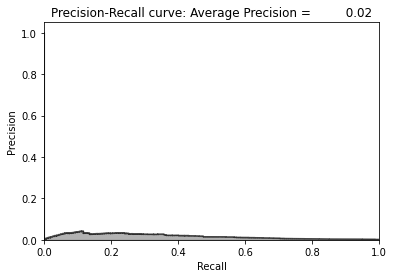

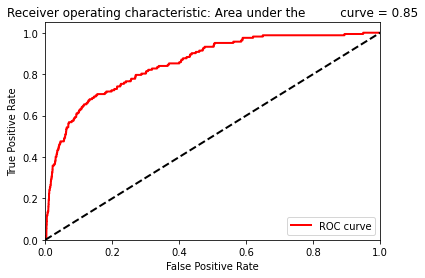

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 30.1373 - accuracy: 0.9080 - val_loss: 0.1992 - val_accuracy: 0.9617
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.4784 - accuracy: 0.9777 - val_loss: 2.2715 - val_accuracy: 0.9932
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.8526 - accuracy: 0.9900 - val_loss: 0.1353 - val_accuracy: 0.9967
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5744 - accuracy: 0.9897 - val_loss: 0.0795 - val_accuracy: 0.9880
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 0.6014 - accuracy: 0.9891 - val_loss: 0.0309 - val_accuracy: 0.9934
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7216 - accuracy: 0.9892 - val_loss: 0.0259 - val_accuracy: 0.9957
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.4602 - accuracy: 0.9894 - val_loss: 0.1256 - val_a

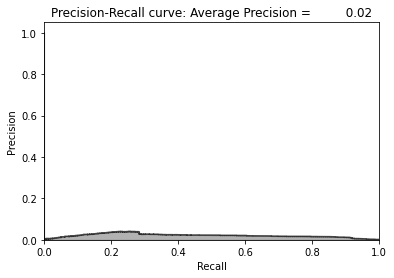

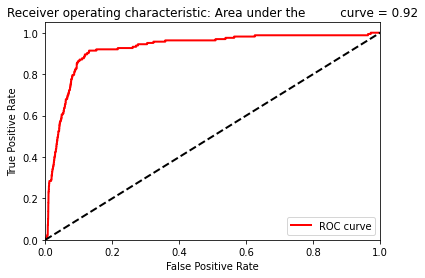

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 35.2643 - accuracy: 0.9123 - val_loss: 0.1588 - val_accuracy: 0.9630
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.3595 - accuracy: 0.9771 - val_loss: 8.3592 - val_accuracy: 0.9894
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.6279 - accuracy: 0.9893 - val_loss: 0.0675 - val_accuracy: 0.9970
Epoch 4/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.5179 - accuracy: 0.9897 - val_loss: 0.0535 - val_accuracy: 0.9952
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.5184 - accuracy: 0.9901 - val_loss: 0.0327 - val_accuracy: 0.9945
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7853 - accuracy: 0.9876 - val_loss: 0.0226 - val_accuracy: 0.9967
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.1049 - accuracy: 0.9903 - val_loss: 0.1047 - val_a

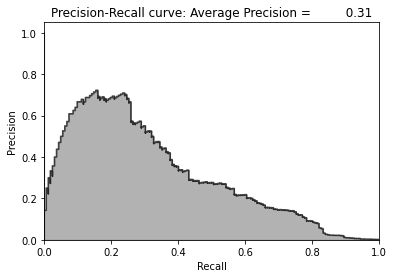

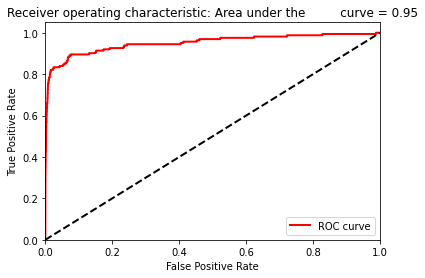

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 23.9081 - accuracy: 0.9158 - val_loss: 0.1552 - val_accuracy: 0.9700
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.6478 - accuracy: 0.9815 - val_loss: 3.7695 - val_accuracy: 0.9899
Epoch 3/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.9820 - accuracy: 0.9899 - val_loss: 0.0919 - val_accuracy: 0.9963
Epoch 4/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.7411 - accuracy: 0.9903 - val_loss: 0.0645 - val_accuracy: 0.9897
Epoch 5/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.6038 - accuracy: 0.9898 - val_loss: 0.0407 - val_accuracy: 0.9921
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.9554 - accuracy: 0.9896 - val_loss: 0.0295 - val_accuracy: 0.9967
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 3.0234 - accuracy: 0.9902 - val_loss: 0.1127 - val_a

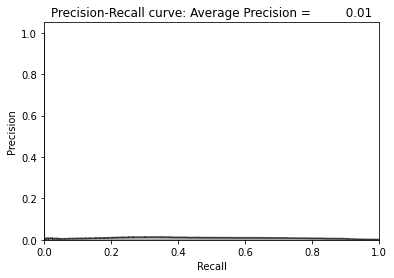

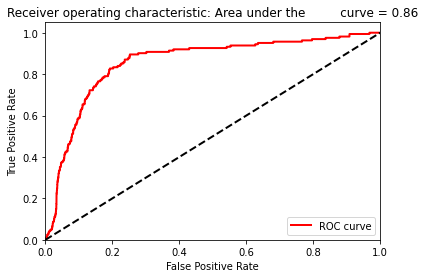

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 12.5052 - accuracy: 0.9265 - val_loss: 0.1449 - val_accuracy: 0.9727
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.2049 - accuracy: 0.9851 - val_loss: 23.5603 - val_accuracy: 0.9898
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7449 - accuracy: 0.9903 - val_loss: 0.1163 - val_accuracy: 0.9971
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5855 - accuracy: 0.9905 - val_loss: 0.0592 - val_accuracy: 0.9944
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5384 - accuracy: 0.9903 - val_loss: 0.0295 - val_accuracy: 0.9898
Epoch 6/10
5964/5964 [==============================] - 11s 2ms/step - loss: 0.7952 - accuracy: 0.9892 - val_loss: 0.0261 - val_accuracy: 0.9905
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.9086 - accuracy: 0.9901 - val_loss: 0.0808 - val_

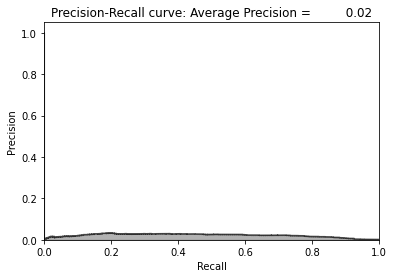

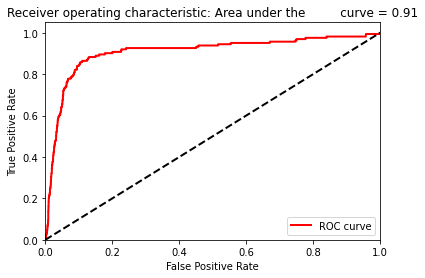

Epoch 1/10
5964/5964 [==============================] - 12s 2ms/step - loss: 22.5167 - accuracy: 0.9196 - val_loss: 0.1332 - val_accuracy: 0.9744
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 1.4908 - accuracy: 0.9874 - val_loss: 3.7999 - val_accuracy: 0.9938
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7766 - accuracy: 0.9907 - val_loss: 0.1517 - val_accuracy: 0.9971
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5269 - accuracy: 0.9914 - val_loss: 0.0780 - val_accuracy: 0.9918
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5916 - accuracy: 0.9895 - val_loss: 0.0361 - val_accuracy: 0.9949
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7485 - accuracy: 0.9909 - val_loss: 0.0251 - val_accuracy: 0.9962
Epoch 7/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.4538 - accuracy: 0.9890 - val_loss: 0.1087 - val_a

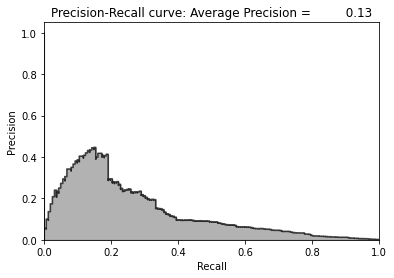

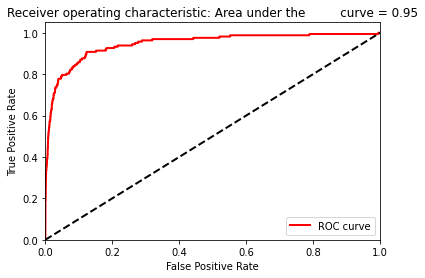

Epoch 1/10
5964/5964 [==============================] - 11s 2ms/step - loss: 14.5378 - accuracy: 0.9326 - val_loss: 0.1298 - val_accuracy: 0.9700
Epoch 2/10
5964/5964 [==============================] - 11s 2ms/step - loss: 1.2986 - accuracy: 0.9848 - val_loss: 3.4325 - val_accuracy: 0.9932
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.7232 - accuracy: 0.9903 - val_loss: 0.0677 - val_accuracy: 0.9968
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 0.5404 - accuracy: 0.9902 - val_loss: 0.0593 - val_accuracy: 0.9924
Epoch 5/10
5964/5964 [==============================] - 14s 2ms/step - loss: 0.4802 - accuracy: 0.9903 - val_loss: 0.0243 - val_accuracy: 0.9976
Epoch 6/10
5964/5964 [==============================] - 15s 2ms/step - loss: 0.5572 - accuracy: 0.9904 - val_loss: 0.0224 - val_accuracy: 0.9961
Epoch 7/10
5964/5964 [==============================] - 14s 2ms/step - loss: 2.1826 - accuracy: 0.9904 - val_loss: 0.1346 - val_a

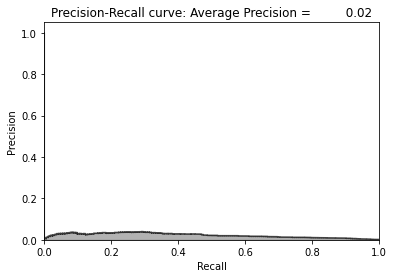

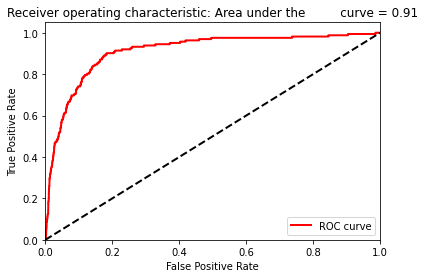

Mean average precision over 10 runs: 0.0885


[0.0237, 0.1993, 0.1255, 0.0167, 0.0207, 0.3131, 0.009, 0.0215, 0.1339, 0.0218]

In [17]:
#Sparse overcomplete autoencoder with linear activation 
# Nodes 29 -> 40 -> 29

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [18]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0885
Coefficient of variation over 10 runs: 1.1031


[0.0237, 0.1993, 0.1255, 0.0167, 0.0207, 0.3131, 0.009, 0.0215, 0.1339, 0.0218]

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 61.6848 - accuracy: 0.8740 - val_loss: 1.9744 - val_accuracy: 0.9035
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 15.8360 - accuracy: 0.9149 - val_loss: 16.9254 - val_accuracy: 0.9341
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.9641 - accuracy: 0.8993 - val_loss: 0.6823 - val_accuracy: 0.9210
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.7314 - accuracy: 0.9016 - val_loss: 1.5002 - val_accuracy: 0.9022
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 6.9863 - accuracy: 0.9049 - val_loss: 1.7395 - val_accuracy: 0.9181
Epoch 6/10
5964/5964 [==============================] - 12s 2ms/step - loss: 8.3578 - accuracy: 0.9050 - val_loss: 0.4896 - val_accuracy: 0.9201
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.0164 - accuracy: 0.9078 - val_loss: 0.6339 - val

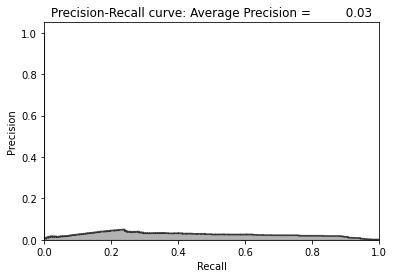

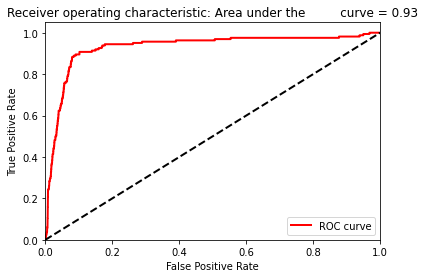

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 77.3785 - accuracy: 0.8808 - val_loss: 1.9134 - val_accuracy: 0.9098
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 14.1243 - accuracy: 0.9112 - val_loss: 24.7228 - val_accuracy: 0.9019
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 10.5117 - accuracy: 0.9062 - val_loss: 0.9524 - val_accuracy: 0.9318
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.1024 - accuracy: 0.9110 - val_loss: 1.0206 - val_accuracy: 0.9333
Epoch 5/10
5964/5964 [==============================] - 15s 3ms/step - loss: 6.8830 - accuracy: 0.9067 - val_loss: 0.6211 - val_accuracy: 0.9259
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.5437 - accuracy: 0.9088 - val_loss: 0.4933 - val_accuracy: 0.9153
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.9620 - accuracy: 0.9070 - val_loss: 0.7907 - va

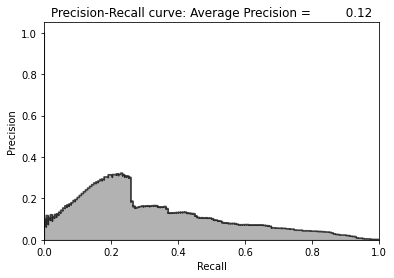

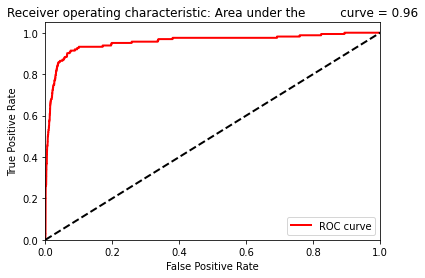

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 68.9086 - accuracy: 0.8719 - val_loss: 1.9728 - val_accuracy: 0.8843
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.6676 - accuracy: 0.9133 - val_loss: 35.5737 - val_accuracy: 0.9321
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.7180 - accuracy: 0.9003 - val_loss: 0.9948 - val_accuracy: 0.9171
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.9252 - accuracy: 0.9026 - val_loss: 1.0615 - val_accuracy: 0.9274
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.6156 - accuracy: 0.8993 - val_loss: 4.2554 - val_accuracy: 0.9045
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.6095 - accuracy: 0.9037 - val_loss: 0.5129 - val_accuracy: 0.9169
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.9794 - accuracy: 0.9020 - val_loss: 0.7922 - val

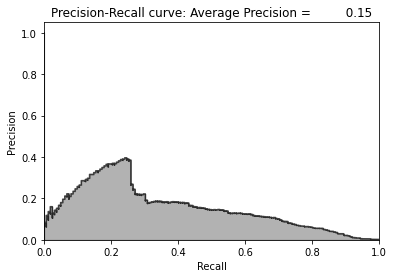

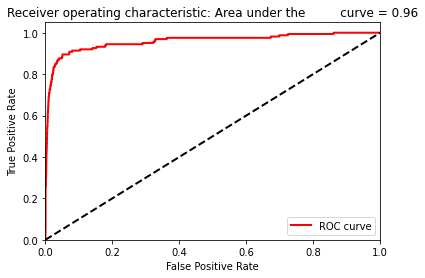

Epoch 1/10
5964/5964 [==============================] - 16s 3ms/step - loss: 68.9069 - accuracy: 0.8771 - val_loss: 1.0403 - val_accuracy: 0.9082
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 14.2167 - accuracy: 0.9142 - val_loss: 62.3384 - val_accuracy: 0.9239
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 10.0333 - accuracy: 0.9056 - val_loss: 0.5992 - val_accuracy: 0.9272
Epoch 4/10
5964/5964 [==============================] - 15s 2ms/step - loss: 8.8559 - accuracy: 0.9092 - val_loss: 1.0247 - val_accuracy: 0.9269
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 6.7789 - accuracy: 0.9049 - val_loss: 1.1577 - val_accuracy: 0.9235
Epoch 6/10
5964/5964 [==============================] - 14s 2ms/step - loss: 8.4031 - accuracy: 0.9080 - val_loss: 0.4335 - val_accuracy: 0.9209
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.4283 - accuracy: 0.9063 - val_loss: 0.7034 - va

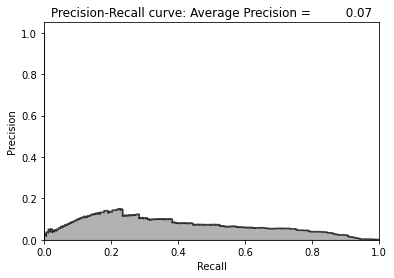

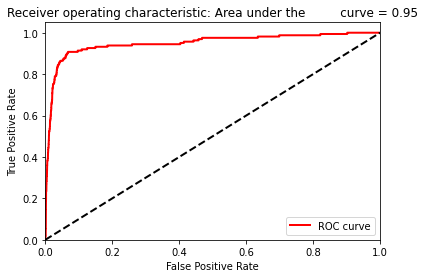

Epoch 1/10
5964/5964 [==============================] - 15s 2ms/step - loss: 69.9214 - accuracy: 0.8731 - val_loss: 1.8160 - val_accuracy: 0.9002
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 12.5979 - accuracy: 0.9041 - val_loss: 23.2818 - val_accuracy: 0.9357
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 9.3559 - accuracy: 0.9115 - val_loss: 0.9073 - val_accuracy: 0.9123
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 9.8008 - accuracy: 0.9048 - val_loss: 1.1514 - val_accuracy: 0.9095
Epoch 5/10
5964/5964 [==============================] - 12s 2ms/step - loss: 7.1488 - accuracy: 0.8951 - val_loss: 1.2330 - val_accuracy: 0.9042
Epoch 6/10
5964/5964 [==============================] - 14s 2ms/step - loss: 8.6399 - accuracy: 0.9006 - val_loss: 0.5989 - val_accuracy: 0.9132
Epoch 7/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.2810 - accuracy: 0.9003 - val_loss: 0.7422 - val

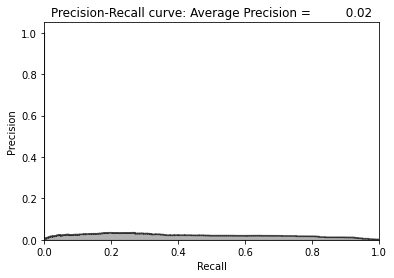

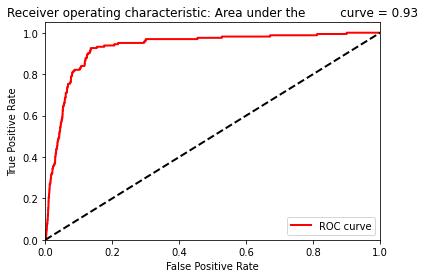

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 88.8170 - accuracy: 0.8706 - val_loss: 1.9984 - val_accuracy: 0.9005
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 14.1978 - accuracy: 0.9172 - val_loss: 51.5934 - val_accuracy: 0.9375
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.8274 - accuracy: 0.9086 - val_loss: 0.7651 - val_accuracy: 0.9190
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.9664 - accuracy: 0.9088 - val_loss: 1.9549 - val_accuracy: 0.9236
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.8557 - accuracy: 0.9020 - val_loss: 3.3764 - val_accuracy: 0.9030
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.3519 - accuracy: 0.9031 - val_loss: 0.4907 - val_accuracy: 0.9104
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.8439 - accuracy: 0.9038 - val_loss: 0.6843 - val

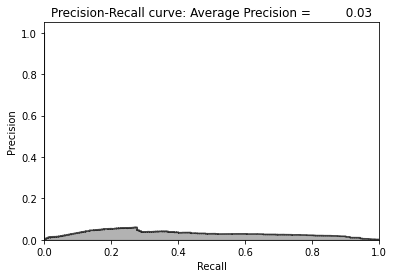

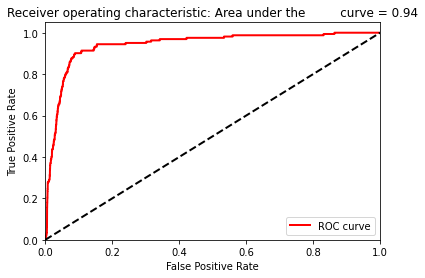

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 73.6603 - accuracy: 0.8879 - val_loss: 2.4216 - val_accuracy: 0.9317
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.8187 - accuracy: 0.9145 - val_loss: 69.0983 - val_accuracy: 0.9171
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 10.2777 - accuracy: 0.9036 - val_loss: 0.5707 - val_accuracy: 0.9048
Epoch 4/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.3395 - accuracy: 0.9039 - val_loss: 1.4755 - val_accuracy: 0.8944
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.4738 - accuracy: 0.8979 - val_loss: 0.9028 - val_accuracy: 0.9160
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.7348 - accuracy: 0.9047 - val_loss: 0.4822 - val_accuracy: 0.9143
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 10.9869 - accuracy: 0.9023 - val_loss: 0.9219 - v

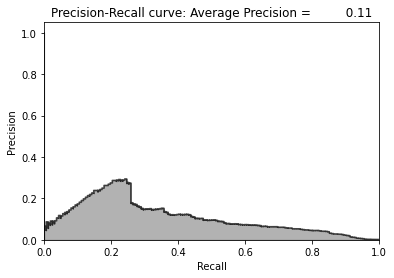

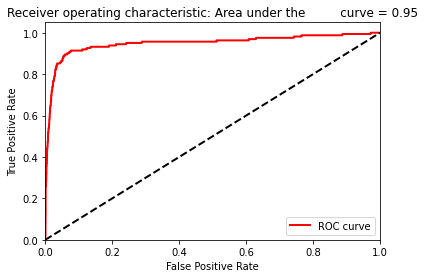

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 71.9016 - accuracy: 0.8702 - val_loss: 2.1987 - val_accuracy: 0.9060
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.9991 - accuracy: 0.9053 - val_loss: 14.9609 - val_accuracy: 0.9290
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.8201 - accuracy: 0.9049 - val_loss: 1.3551 - val_accuracy: 0.9232
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.2254 - accuracy: 0.9048 - val_loss: 1.7631 - val_accuracy: 0.9051
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.7928 - accuracy: 0.9049 - val_loss: 1.3604 - val_accuracy: 0.9158
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.3820 - accuracy: 0.8998 - val_loss: 0.5377 - val_accuracy: 0.9009
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 10.8733 - accuracy: 0.9020 - val_loss: 0.7563 - va

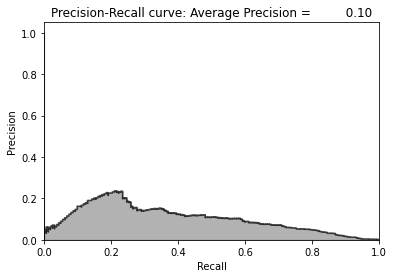

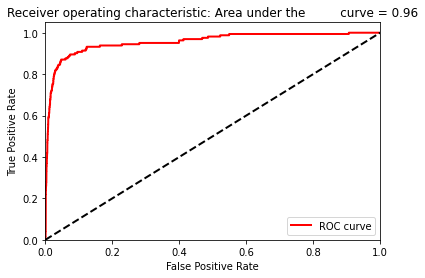

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 77.5686 - accuracy: 0.8631 - val_loss: 1.5775 - val_accuracy: 0.9016
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 14.2427 - accuracy: 0.9068 - val_loss: 17.9916 - val_accuracy: 0.9270
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.6545 - accuracy: 0.9039 - val_loss: 0.4443 - val_accuracy: 0.9252
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.3418 - accuracy: 0.9037 - val_loss: 1.8133 - val_accuracy: 0.9069
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.2538 - accuracy: 0.9028 - val_loss: 0.9178 - val_accuracy: 0.9232
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.7684 - accuracy: 0.9064 - val_loss: 0.4991 - val_accuracy: 0.9124
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.8737 - accuracy: 0.9080 - val_loss: 0.7246 - val

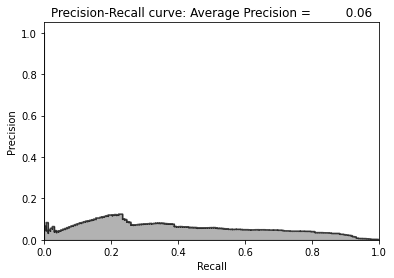

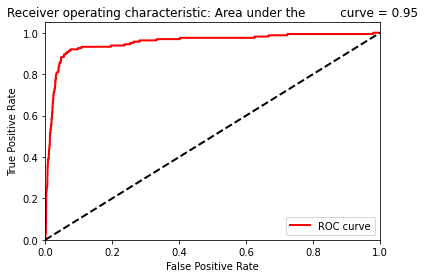

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 57.1348 - accuracy: 0.8775 - val_loss: 1.9135 - val_accuracy: 0.8927
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 12.7051 - accuracy: 0.9096 - val_loss: 27.3825 - val_accuracy: 0.9294
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 10.0579 - accuracy: 0.9099 - val_loss: 0.7259 - val_accuracy: 0.9092
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.4715 - accuracy: 0.9065 - val_loss: 1.5925 - val_accuracy: 0.8877
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.6357 - accuracy: 0.9009 - val_loss: 1.6568 - val_accuracy: 0.9127
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.8380 - accuracy: 0.9063 - val_loss: 0.4887 - val_accuracy: 0.9299
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.9976 - accuracy: 0.9082 - val_loss: 0.8477 - va

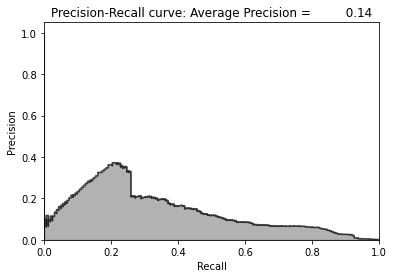

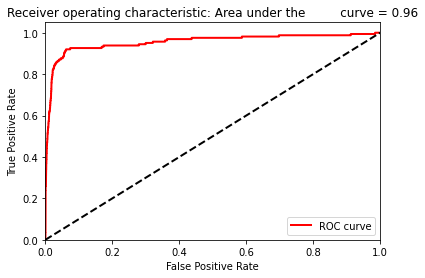

Mean average precision over 10 runs: 0.0825


[0.0255, 0.118, 0.1543, 0.0702, 0.021, 0.0299, 0.1079, 0.1022, 0.0577, 0.1388]

In [19]:
#Two Layer sparse overcomplete autoencoder with linear activation and dropout
#Nodes 29 -> 40 -> 29
#5% dropout percentage
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 62.7644 - accuracy: 0.8753 - val_loss: 1.8703 - val_accuracy: 0.9058
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 14.1060 - accuracy: 0.9087 - val_loss: 27.5603 - val_accuracy: 0.9428
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.9977 - accuracy: 0.9001 - val_loss: 0.6720 - val_accuracy: 0.9116
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.2886 - accuracy: 0.8975 - val_loss: 2.3423 - val_accuracy: 0.9180
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 7.1370 - accuracy: 0.8955 - val_loss: 3.0610 - val_accuracy: 0.9110
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.5553 - accuracy: 0.8963 - val_loss: 0.4661 - val_accuracy: 0.9351
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.0389 - accuracy: 0.8998 - val_loss: 0.7163 - val

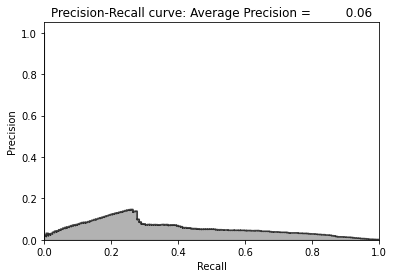

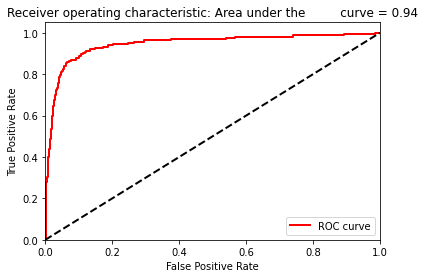

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 71.0315 - accuracy: 0.8667 - val_loss: 2.0400 - val_accuracy: 0.9222
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.4017 - accuracy: 0.9047 - val_loss: 41.4842 - val_accuracy: 0.9462
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.8248 - accuracy: 0.9070 - val_loss: 0.3749 - val_accuracy: 0.9357
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.2540 - accuracy: 0.9043 - val_loss: 0.8052 - val_accuracy: 0.9328
Epoch 5/10
5964/5964 [==============================] - 16s 3ms/step - loss: 7.0182 - accuracy: 0.9018 - val_loss: 1.5300 - val_accuracy: 0.9217
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.9872 - accuracy: 0.9036 - val_loss: 0.4695 - val_accuracy: 0.9324
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.3074 - accuracy: 0.9026 - val_loss: 0.7525 - val

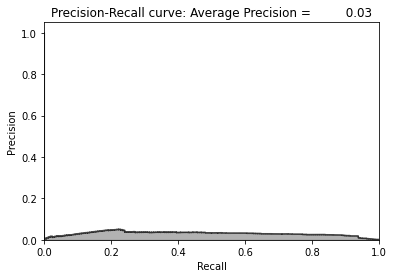

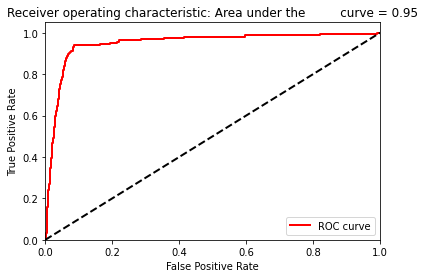

Epoch 1/10
5964/5964 [==============================] - 16s 3ms/step - loss: 67.6182 - accuracy: 0.8664 - val_loss: 1.5359 - val_accuracy: 0.8869
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 14.5502 - accuracy: 0.9063 - val_loss: 19.8747 - val_accuracy: 0.9385
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.9299 - accuracy: 0.9012 - val_loss: 1.1265 - val_accuracy: 0.9248
Epoch 4/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.3150 - accuracy: 0.8995 - val_loss: 1.1582 - val_accuracy: 0.9211
Epoch 5/10
5964/5964 [==============================] - 14s 2ms/step - loss: 7.3180 - accuracy: 0.8938 - val_loss: 2.8029 - val_accuracy: 0.9004
Epoch 6/10
5964/5964 [==============================] - 14s 2ms/step - loss: 8.4495 - accuracy: 0.8988 - val_loss: 0.4232 - val_accuracy: 0.9356
Epoch 7/10
5964/5964 [==============================] - 15s 2ms/step - loss: 9.0767 - accuracy: 0.9027 - val_loss: 0.5978 - val

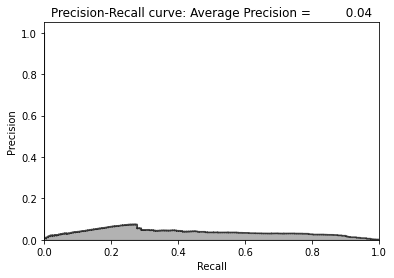

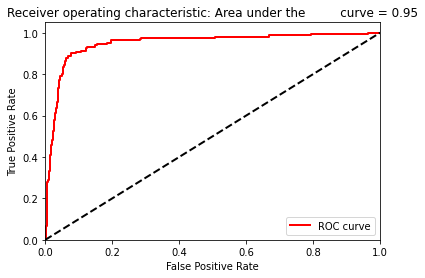

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 48.9220 - accuracy: 0.8754 - val_loss: 3.4615 - val_accuracy: 0.9049
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 12.8848 - accuracy: 0.9111 - val_loss: 19.3568 - val_accuracy: 0.9480
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 10.0878 - accuracy: 0.8995 - val_loss: 1.4927 - val_accuracy: 0.9209
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.3560 - accuracy: 0.8899 - val_loss: 1.2115 - val_accuracy: 0.9100
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.7812 - accuracy: 0.8945 - val_loss: 4.1109 - val_accuracy: 0.9036
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.8264 - accuracy: 0.8980 - val_loss: 0.4142 - val_accuracy: 0.9345
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.8954 - accuracy: 0.8994 - val_loss: 0.6313 - va

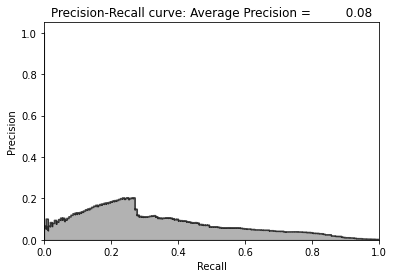

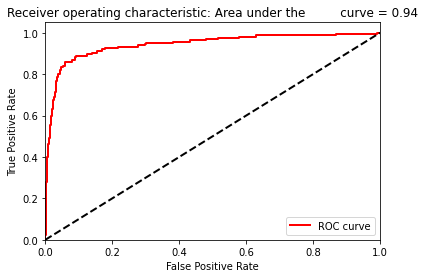

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 55.4619 - accuracy: 0.8784 - val_loss: 1.1310 - val_accuracy: 0.9299
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 13.7778 - accuracy: 0.9081 - val_loss: 27.7946 - val_accuracy: 0.9319
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.2595 - accuracy: 0.9085 - val_loss: 0.5226 - val_accuracy: 0.9320
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.2520 - accuracy: 0.9025 - val_loss: 1.1903 - val_accuracy: 0.9333
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 6.7658 - accuracy: 0.9003 - val_loss: 0.7106 - val_accuracy: 0.9203
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.4661 - accuracy: 0.8980 - val_loss: 0.4591 - val_accuracy: 0.9153
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.8731 - accuracy: 0.8982 - val_loss: 0.6312 - val

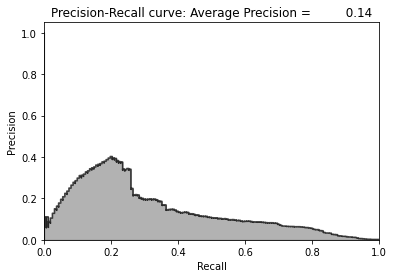

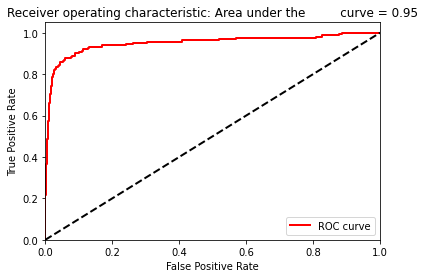

Mean average precision over 10 runs: 0.0687


[0.0553, 0.03, 0.0361, 0.0792, 0.1428]

In [20]:
#Two layer denoising overcomplete autoencoder with linear activation and sparsity reguarizer and dropout
#Nodes 29 -> 40 -> 29 
#Drop out percentage = 5%

# 5 runs - We will capture mean of average precision
test_scores = []

#Addition of noise to dataset
noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 

for i in range(0,5):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [22]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0687
Coefficient of variation over 10 runs: 0.5947


[0.0553, 0.03, 0.0361, 0.0792, 0.1428]

Epoch 1/10
5964/5964 [==============================] - 16s 2ms/step - loss: 76.5062 - accuracy: 0.8723 - val_loss: 1.0532 - val_accuracy: 0.8817
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 15.3928 - accuracy: 0.8801 - val_loss: 26.2007 - val_accuracy: 0.8934
Epoch 3/10
5964/5964 [==============================] - 15s 2ms/step - loss: 11.2599 - accuracy: 0.8854 - val_loss: 1.4304 - val_accuracy: 0.8961
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.2639 - accuracy: 0.8762 - val_loss: 1.4338 - val_accuracy: 0.8982
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.1666 - accuracy: 0.8798 - val_loss: 0.5996 - val_accuracy: 0.9153
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.4775 - accuracy: 0.8827 - val_loss: 0.4843 - val_accuracy: 0.9046
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.6093 - accuracy: 0.8771 - val_loss: 0.7185 - va

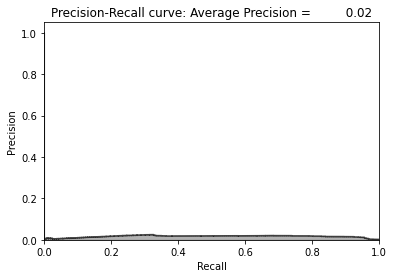

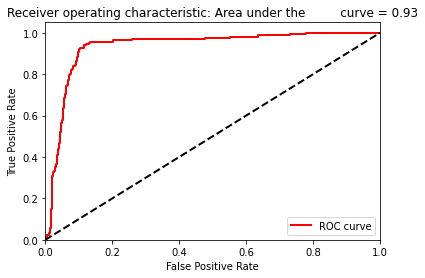

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 82.7100 - accuracy: 0.8673 - val_loss: 6.5007 - val_accuracy: 0.9228
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 14.3901 - accuracy: 0.8790 - val_loss: 27.5674 - val_accuracy: 0.9004
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.5900 - accuracy: 0.8784 - val_loss: 1.2362 - val_accuracy: 0.8936
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.1117 - accuracy: 0.8786 - val_loss: 0.8701 - val_accuracy: 0.8969
Epoch 5/10
5964/5964 [==============================] - 14s 2ms/step - loss: 7.3895 - accuracy: 0.8831 - val_loss: 0.6416 - val_accuracy: 0.9149
Epoch 6/10
5964/5964 [==============================] - 15s 2ms/step - loss: 8.7296 - accuracy: 0.8814 - val_loss: 0.4696 - val_accuracy: 0.9002
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.8268 - accuracy: 0.8773 - val_loss: 0.4706 - val

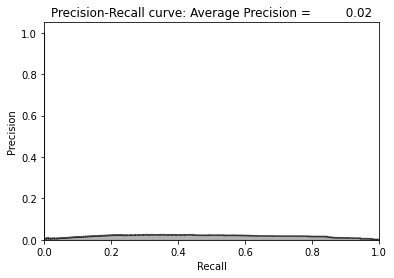

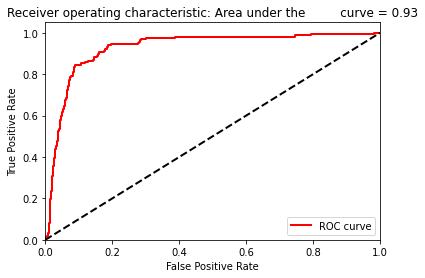

Epoch 1/10
5964/5964 [==============================] - 15s 2ms/step - loss: 84.7261 - accuracy: 0.8578 - val_loss: 1.5621 - val_accuracy: 0.8667
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 14.0123 - accuracy: 0.8678 - val_loss: 38.2015 - val_accuracy: 0.8878
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.9969 - accuracy: 0.8824 - val_loss: 0.4766 - val_accuracy: 0.8960
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.9078 - accuracy: 0.8760 - val_loss: 1.0503 - val_accuracy: 0.9036
Epoch 5/10
5964/5964 [==============================] - 14s 2ms/step - loss: 7.5615 - accuracy: 0.8798 - val_loss: 2.0512 - val_accuracy: 0.9008
Epoch 6/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.7450 - accuracy: 0.8789 - val_loss: 0.5277 - val_accuracy: 0.9000
Epoch 7/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.5170 - accuracy: 0.8721 - val_loss: 0.5756 - val

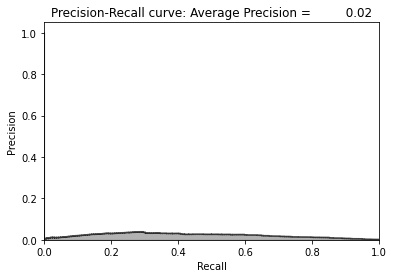

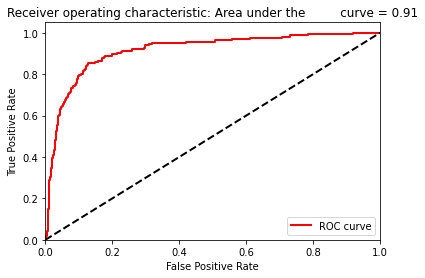

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 49.5978 - accuracy: 0.8671 - val_loss: 3.2028 - val_accuracy: 0.8934
Epoch 2/10
5964/5964 [==============================] - 14s 2ms/step - loss: 12.4849 - accuracy: 0.8678 - val_loss: 22.3897 - val_accuracy: 0.8828
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.4701 - accuracy: 0.8733 - val_loss: 0.5845 - val_accuracy: 0.8772
Epoch 4/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.8396 - accuracy: 0.8729 - val_loss: 0.7977 - val_accuracy: 0.8876
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.1078 - accuracy: 0.8786 - val_loss: 0.5788 - val_accuracy: 0.9106
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.8774 - accuracy: 0.8764 - val_loss: 0.5464 - val_accuracy: 0.8909
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.2821 - accuracy: 0.8684 - val_loss: 0.5531 - val

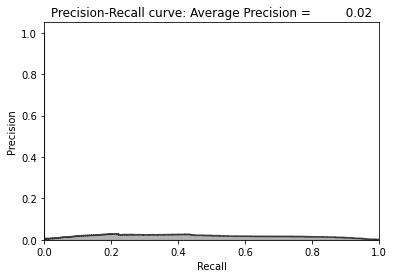

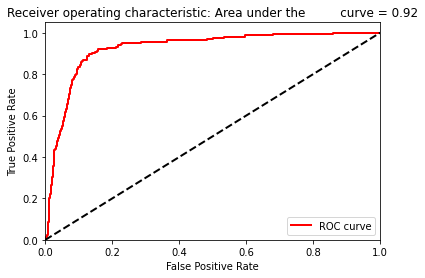

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 56.4284 - accuracy: 0.8733 - val_loss: 1.4180 - val_accuracy: 0.8954
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 12.6406 - accuracy: 0.8686 - val_loss: 39.9318 - val_accuracy: 0.8947
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.5477 - accuracy: 0.8706 - val_loss: 0.6176 - val_accuracy: 0.8896
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 10.5221 - accuracy: 0.8741 - val_loss: 1.8153 - val_accuracy: 0.8833
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 7.0245 - accuracy: 0.8799 - val_loss: 0.7638 - val_accuracy: 0.8971
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.2663 - accuracy: 0.8793 - val_loss: 0.4459 - val_accuracy: 0.9166
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 11.3143 - accuracy: 0.8741 - val_loss: 0.6901 - v

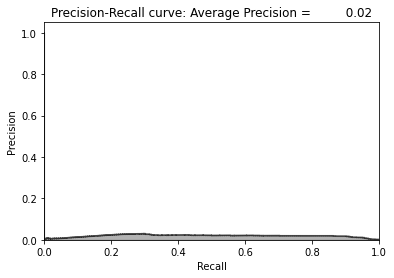

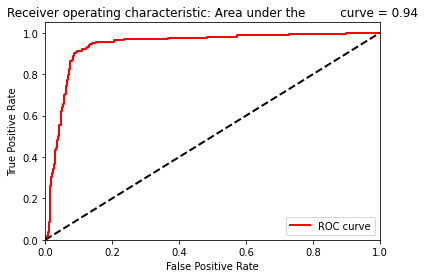

Epoch 1/10
5964/5964 [==============================] - 14s 2ms/step - loss: 64.5293 - accuracy: 0.8737 - val_loss: 2.5128 - val_accuracy: 0.8940
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 14.6182 - accuracy: 0.8799 - val_loss: 14.8087 - val_accuracy: 0.9141
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.4637 - accuracy: 0.8860 - val_loss: 0.5463 - val_accuracy: 0.8984
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.6878 - accuracy: 0.8830 - val_loss: 2.5165 - val_accuracy: 0.9120
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 7.5489 - accuracy: 0.8864 - val_loss: 0.9947 - val_accuracy: 0.9165
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.4132 - accuracy: 0.8852 - val_loss: 0.4012 - val_accuracy: 0.9128
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.3886 - accuracy: 0.8872 - val_loss: 0.4788 - val

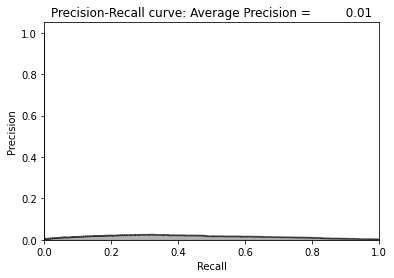

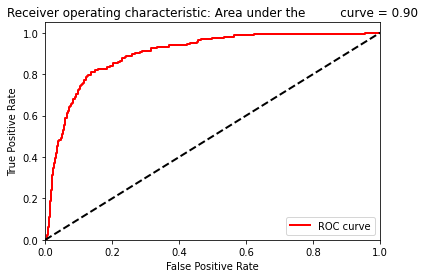

Epoch 1/10
5964/5964 [==============================] - 15s 2ms/step - loss: 90.6291 - accuracy: 0.8571 - val_loss: 1.2179 - val_accuracy: 0.8674
Epoch 2/10
5964/5964 [==============================] - 16s 3ms/step - loss: 14.1008 - accuracy: 0.8621 - val_loss: 36.5819 - val_accuracy: 0.8798
Epoch 3/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.8695 - accuracy: 0.8664 - val_loss: 0.6129 - val_accuracy: 0.8925
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.3346 - accuracy: 0.8671 - val_loss: 1.8742 - val_accuracy: 0.8882
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 7.4748 - accuracy: 0.8772 - val_loss: 0.6785 - val_accuracy: 0.9035
Epoch 6/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.3436 - accuracy: 0.8765 - val_loss: 0.6674 - val_accuracy: 0.9049
Epoch 7/10
5964/5964 [==============================] - 14s 2ms/step - loss: 10.1955 - accuracy: 0.8720 - val_loss: 0.7689 - va

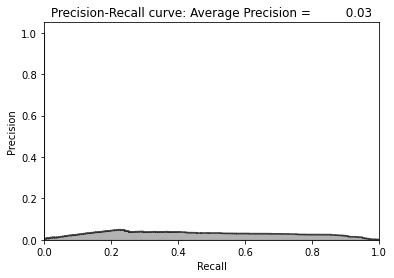

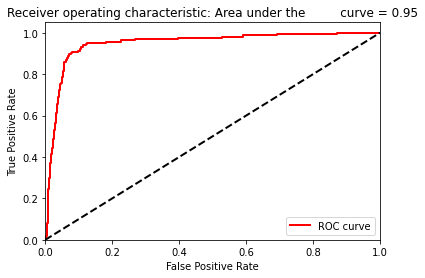

Epoch 1/10
5964/5964 [==============================] - 15s 2ms/step - loss: 66.4511 - accuracy: 0.8687 - val_loss: 1.4455 - val_accuracy: 0.8909
Epoch 2/10
5964/5964 [==============================] - 19s 3ms/step - loss: 13.3319 - accuracy: 0.8756 - val_loss: 28.4532 - val_accuracy: 0.9063
Epoch 3/10
5964/5964 [==============================] - 16s 3ms/step - loss: 8.9667 - accuracy: 0.8799 - val_loss: 0.9655 - val_accuracy: 0.9056
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.1803 - accuracy: 0.8804 - val_loss: 3.4286 - val_accuracy: 0.8988
Epoch 5/10
5964/5964 [==============================] - 14s 2ms/step - loss: 9.5524 - accuracy: 0.8791 - val_loss: 0.4615 - val_accuracy: 0.8928
Epoch 6/10
5964/5964 [==============================] - 16s 3ms/step - loss: 9.2300 - accuracy: 0.8775 - val_loss: 0.5510 - val_accuracy: 0.9124
Epoch 7/10
5964/5964 [==============================] - 16s 3ms/step - loss: 9.6367 - accuracy: 0.8752 - val_loss: 0.6064 - val

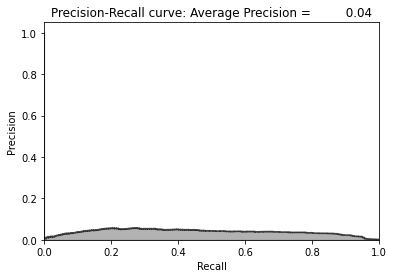

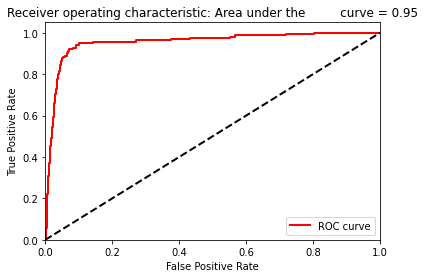

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 89.9058 - accuracy: 0.8697 - val_loss: 1.8563 - val_accuracy: 0.8872
Epoch 2/10
5964/5964 [==============================] - 12s 2ms/step - loss: 14.0468 - accuracy: 0.8829 - val_loss: 5.1914 - val_accuracy: 0.9164
Epoch 3/10
5964/5964 [==============================] - 12s 2ms/step - loss: 9.7164 - accuracy: 0.8898 - val_loss: 0.5655 - val_accuracy: 0.9232
Epoch 4/10
5964/5964 [==============================] - 12s 2ms/step - loss: 9.6808 - accuracy: 0.8780 - val_loss: 0.7427 - val_accuracy: 0.8983
Epoch 5/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.5126 - accuracy: 0.8809 - val_loss: 0.8105 - val_accuracy: 0.9001
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.9279 - accuracy: 0.8798 - val_loss: 0.5615 - val_accuracy: 0.9014
Epoch 7/10
5964/5964 [==============================] - 13s 2ms/step - loss: 8.0418 - accuracy: 0.8752 - val_loss: 0.9043 - val_

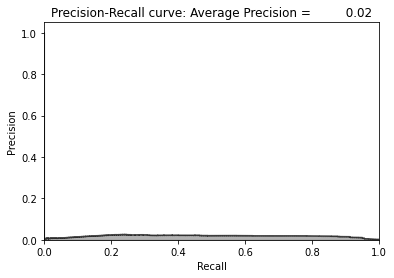

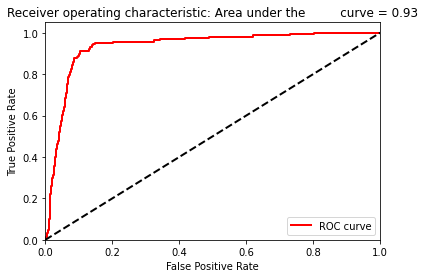

Epoch 1/10
5964/5964 [==============================] - 13s 2ms/step - loss: 89.0766 - accuracy: 0.8625 - val_loss: 0.8527 - val_accuracy: 0.8871
Epoch 2/10
5964/5964 [==============================] - 13s 2ms/step - loss: 12.8692 - accuracy: 0.8764 - val_loss: 17.1429 - val_accuracy: 0.8961
Epoch 3/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.5302 - accuracy: 0.8810 - val_loss: 2.2883 - val_accuracy: 0.8828
Epoch 4/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.4895 - accuracy: 0.8775 - val_loss: 1.6601 - val_accuracy: 0.8921
Epoch 5/10
5964/5964 [==============================] - 15s 2ms/step - loss: 7.4369 - accuracy: 0.8812 - val_loss: 1.2117 - val_accuracy: 0.9067
Epoch 6/10
5964/5964 [==============================] - 13s 2ms/step - loss: 9.4209 - accuracy: 0.8773 - val_loss: 0.4893 - val_accuracy: 0.9007
Epoch 7/10
5964/5964 [==============================] - 12s 2ms/step - loss: 10.2622 - accuracy: 0.8662 - val_loss: 0.6339 - va

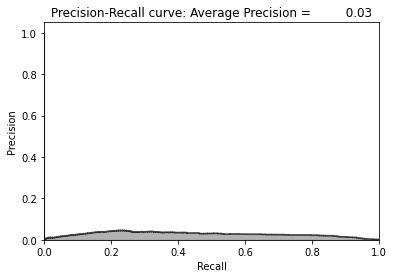

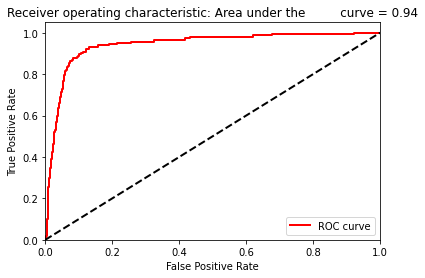

Mean average precision over 10 runs: 0.0221


[0.0168, 0.0177, 0.0212, 0.0181, 0.0193, 0.015, 0.0291, 0.0385, 0.0182, 0.0271]

In [23]:
# Two layer denoising overcomplete autoencoder with ReLU activation
# And sparsity regularizer and dropout
# 29 -> 40 -> 29

# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='relu',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [26]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.0221
Coefficient of variation over 10 runs: 0.3131


[0.0168, 0.0177, 0.0212, 0.0181, 0.0193, 0.015, 0.0291, 0.0385, 0.0182, 0.0271]

In [25]:
print('test')

test
